In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_csv('final_combined_dataset.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1,-2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[3, 4])
data = data.dropna().reset_index(drop=True)
data['geocode'] = data['geocode'].astype(str)  # Ensure categorical features are in string format

# Now 'transformed_df' contains the transformed data with the correct types
train_data = data[data['date'].dt.year <= 2018]
test_data = data[data['date'].dt.year >= 2019]
pd.set_option('display.max_columns', None)

X_train = train_data.drop(columns=['cases','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_lag-2'])
y_test = test_data[['cases_lag-2']]



In [4]:
X_test

date    week  population  tempe_min  humidity_max  humidity_avg  \
362   2019-01-06  201902      207044  22.428571     86.854376     86.854376   
363   2019-01-13  201903      207044  21.285714     92.424487     71.477373   
364   2019-01-20  201904      207044  21.285714     94.112314     71.807705   
365   2019-01-27  201905      207044  19.714286     92.337921     55.203293   
366   2019-02-03  201906      207044  19.857143     93.229270     81.677330   
...          ...     ...         ...        ...           ...           ...   
51683 2022-11-13  202246      273988  20.857143     90.883001     79.522168   
51684 2022-11-20  202247      273988  20.714286     93.280477     82.167320   
51685 2022-11-27  202248      273988  21.857143     95.875069     82.840922   
51686 2022-12-04  202249      273988  21.857143     92.543531     80.151192   
51687 2022-12-11  202250      273988  21.000000     94.213747     79.480439   

       humidity_min   temp_avg   temp_max            city  geocode       vim  \
362       86.854376  22.428571  22.428571  angra dos reis  3300100  0.861404   
363       56.908133  26.472528  30.571429  angra dos reis  3300100  0.863230   
364       53.968875  26.780220  31.571429  angra dos reis  3300100  0.864936   
365       35.470493  29.945055  34.857143  angra dos reis  3300100  0.866532   
366       69.523444  22.925519  25.428571  angra dos reis  3300100  0.868082   
...             ...        ...        ...             ...      ...       ...   
51683     61.268456  23.714286  27.857143   volta redonda  3306305  0.645087   
51684     67.014975  23.726190  27.000000   volta redonda  3306305  0.664894   
51685     61.313170  25.507143  30.857143   volta redonda  3306305  0.683798   
51686     64.110460  24.903139  28.142857   volta redonda  3306305  0.701526   
51687     59.964030  24.597222  28.500000   volta redonda  3306305  0.717158   

       vim_monthly  precipitation_avg_ordinary_kriging  \
362       0.862133                              0.0876   
363       0.862133                              0.7152   
364       0.862133                              4.6569   
365       0.862133                              0.0000   
366       0.869167                              5.9758   
...            ...                                 ...   
51683     0.642000                              2.2254   
51684     0.642000                              3.2501   
51685     0.642000                              4.9788   
51686     0.716900                              1.8253   
51687     0.716900                              3.2077   

       precipitation_max_ordinary_kriging  \
362                                0.6407   
363                                4.5976   
364                               22.6081   
365                                0.0000   
366                               25.7629   
...                                   ...   
51683                              9.5493   
51684                             15.0136   
51685                             17.2846   
51686                              8.1846   
51687                             13.9077   

       precipitation_avg_regression_kriging  \
362                                  0.4017   
363                                  0.8568   
364                                  4.9196   
365                                  0.0000   
366                                  8.4071   
...                                     ...   
51683                                2.1986   
51684                                3.3057   
51685                                4.8787   
51686                                1.9016   
51687                                3.6355   

       precipitation_max_regression_kriging       long        lat  \
362                                  0.6597 -44.319627 -23.009116   
363                                  4.1448 -44.319627 -23.009116   
364                                 24.6006 -44.319627 -23.009116   
365                    

C:\Users\user\AppData\Local\Temp\ipykernel_5200\1735716119.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])


Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 0.0176385	total: 183ms	remaining: 3m 3s
100:	learn: 0.0122180	total: 3.25s	remaining: 28.9s
200:	learn: 0.0089551	total: 6.18s	remaining: 24.6s
300:	learn: 0.0069498	total: 9.26s	remaining: 21.5s
400:	learn: 0.0056601	total: 12.3s	remaining: 18.4s
500:	learn: 0.0047639	total: 15.3s	remaining: 15.2s
600:	learn: 0.0040914	total: 18.4s	remaining: 12.2s
700:	learn: 0.0036754	total: 21.9s	remaining: 9.34s
800:	learn: 0.0033885	total: 25s	remaining: 6.21s
900:	learn: 0.0031737	total: 28.1s	remaining: 3.08s
999:	learn: 0.0029753	total: 31.5s	remaining: 0us
Best Parameters: {'verbose': 100, 'random_strength': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 13, 'iterations': 1000, 'early_stopping_rounds': 100, 'depth': 6, 'border_count': 64, 'boosting_type': 'Plain', 'bagging_temperature': 5}

CatBoost Model Performance:
CatBoost RMSE (Train): 43.572831851435346
CatBoost RMSE (Test): 12.184866797609313
CatBoost R² (Train): 0.97200

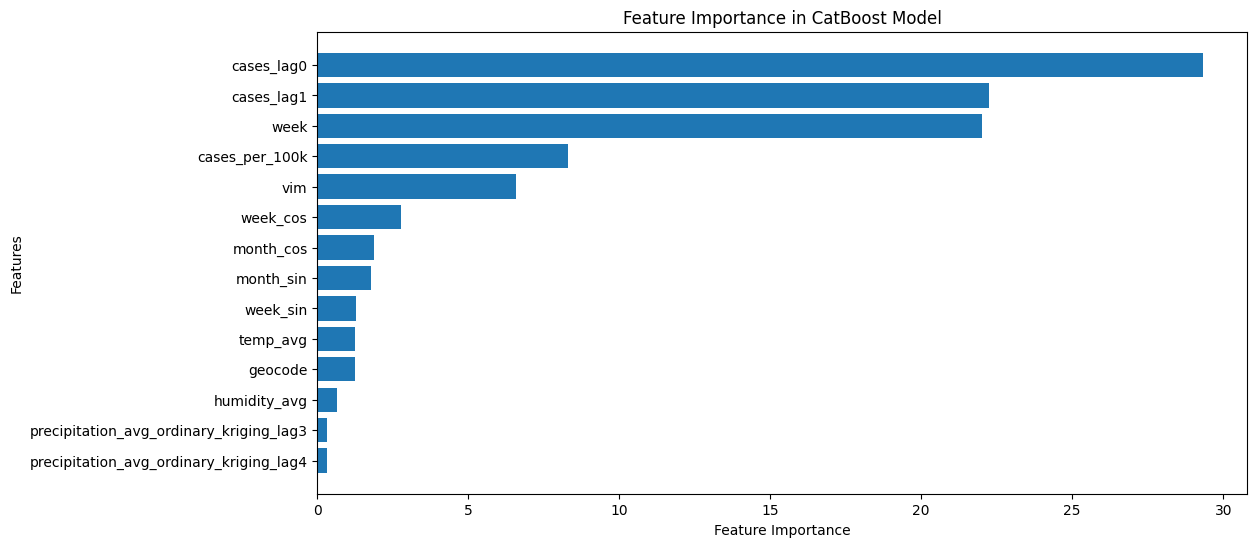

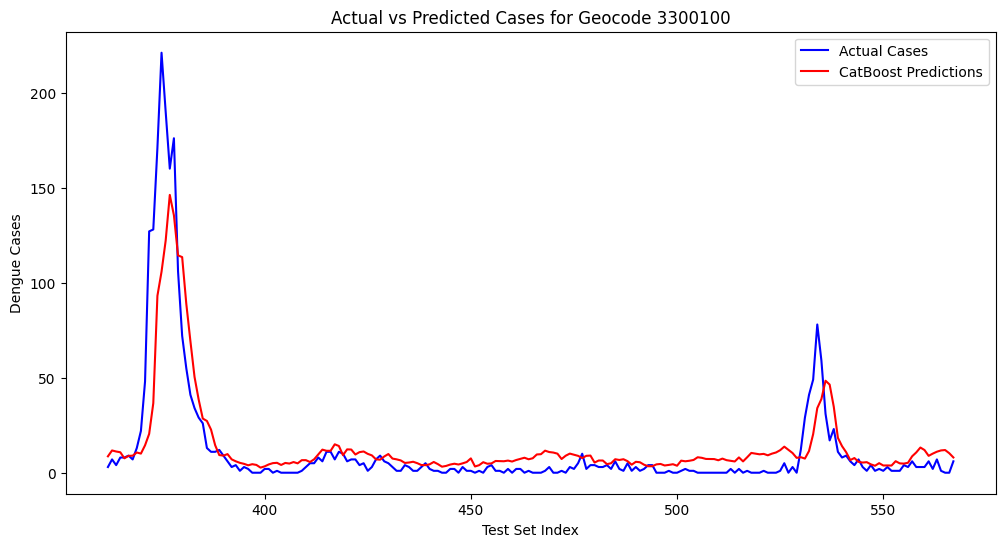

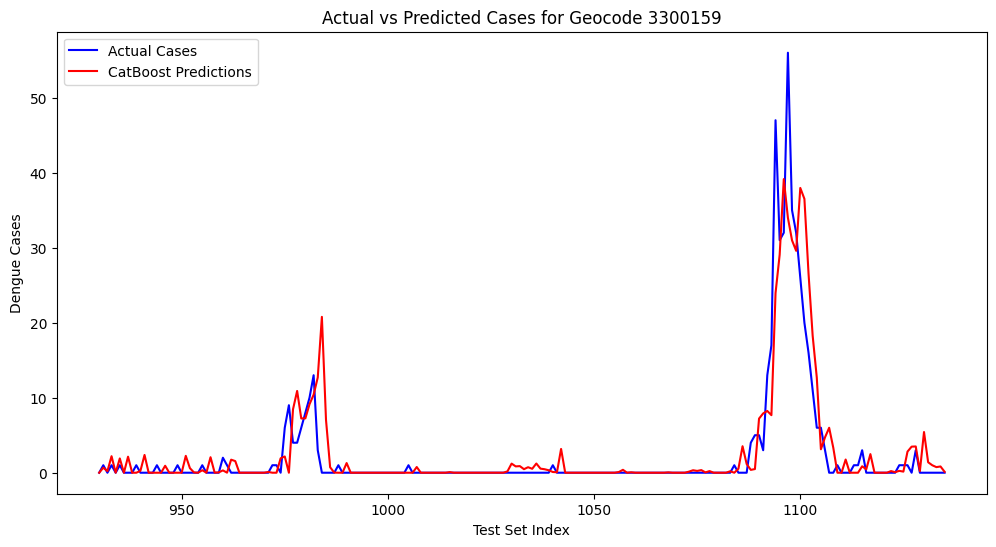

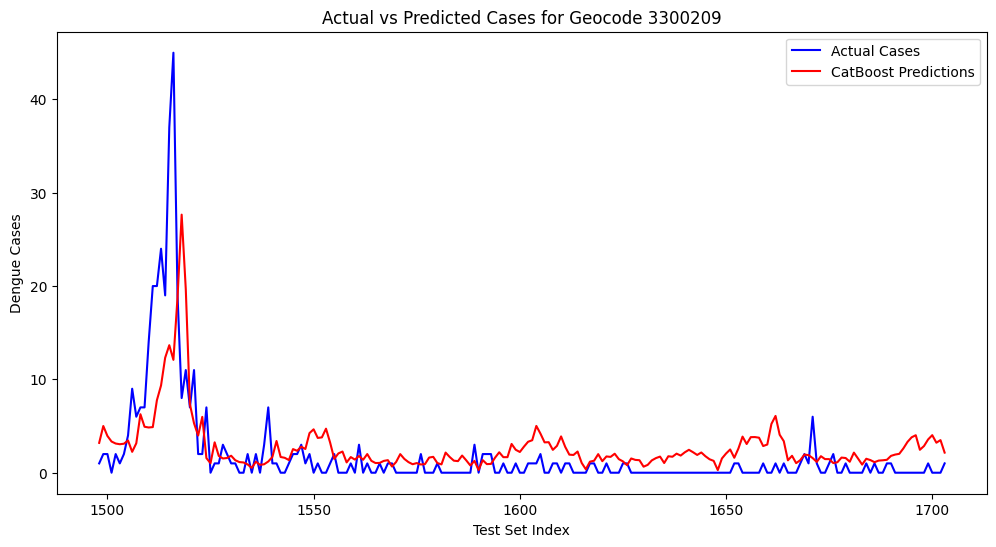

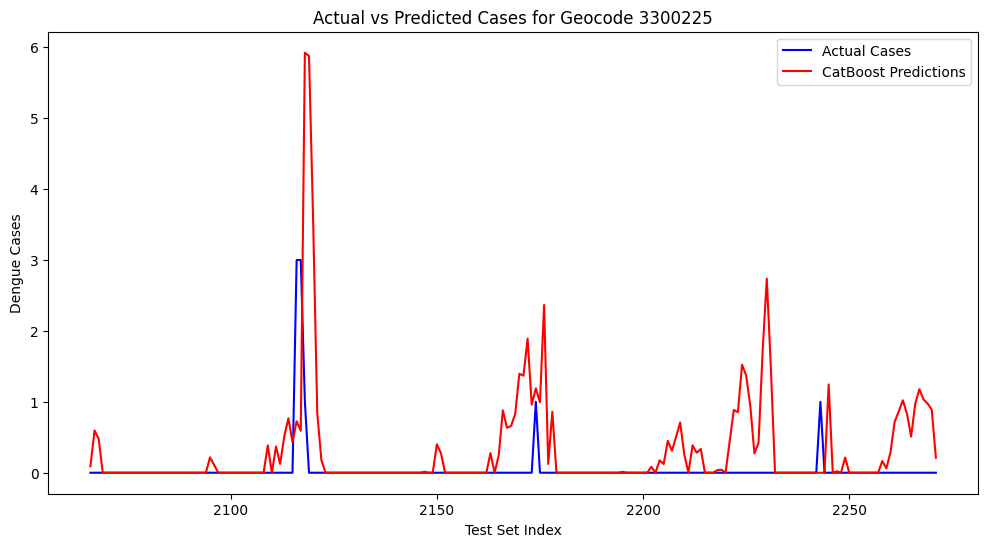

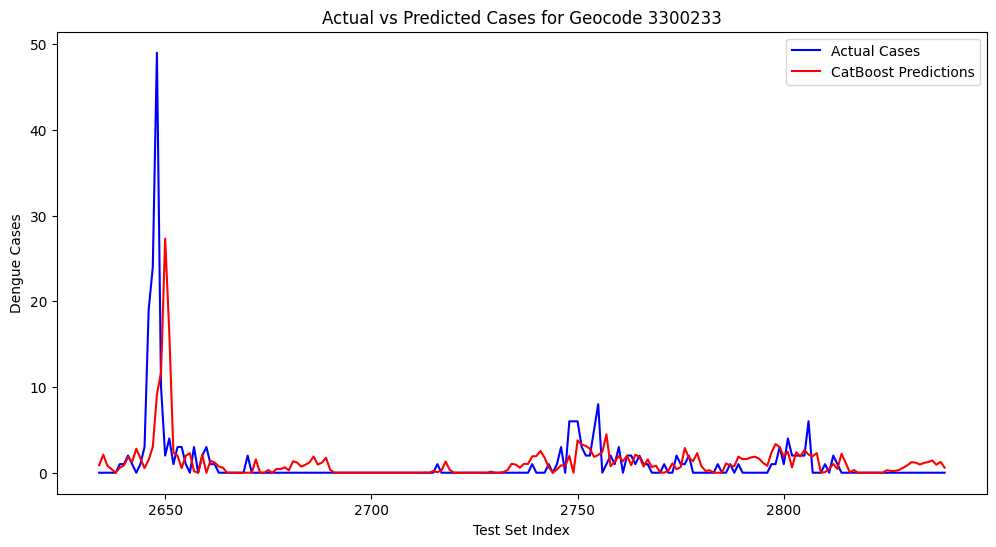

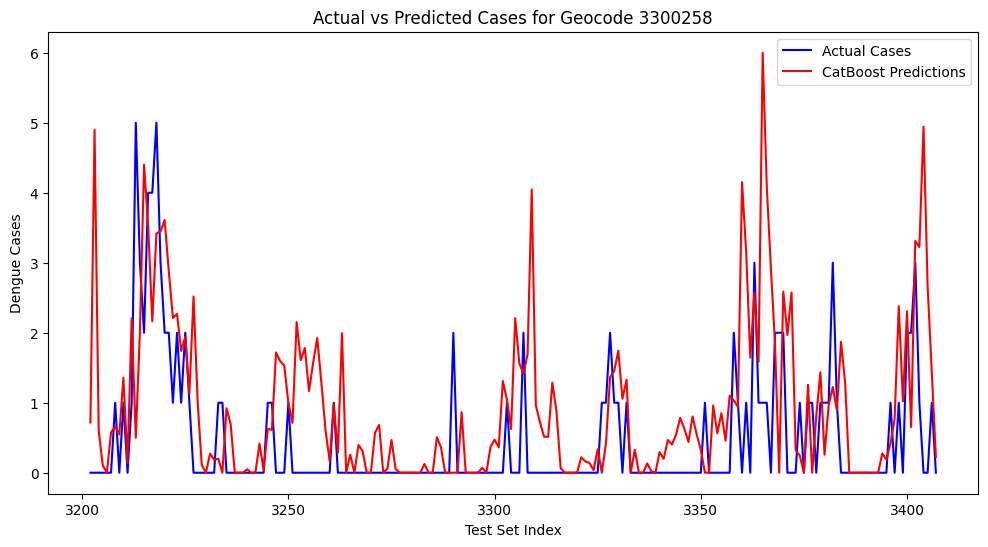

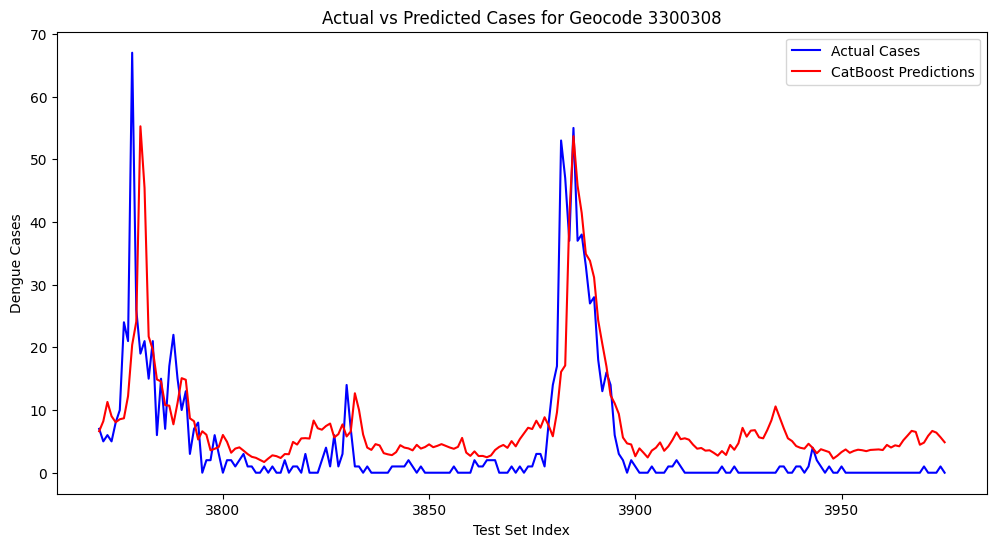

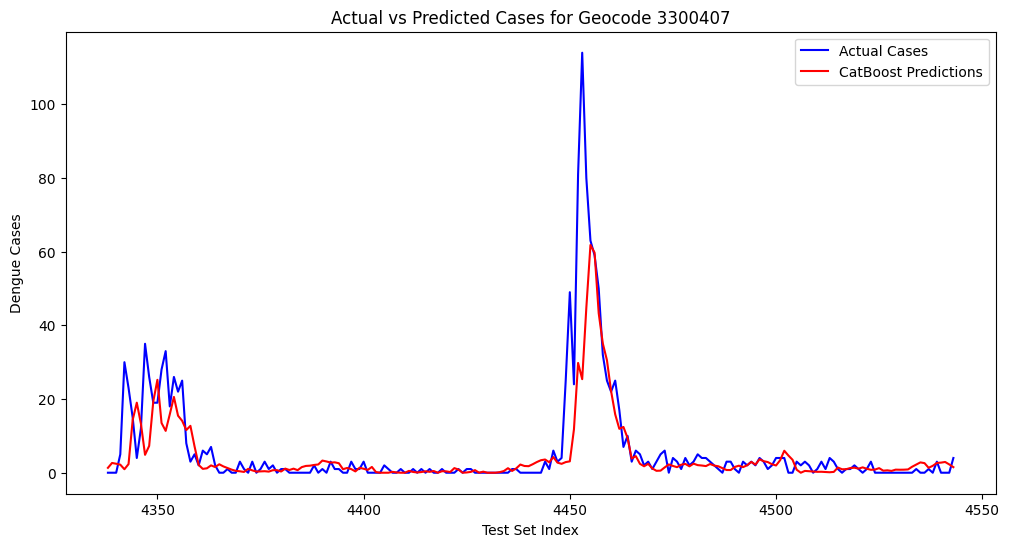

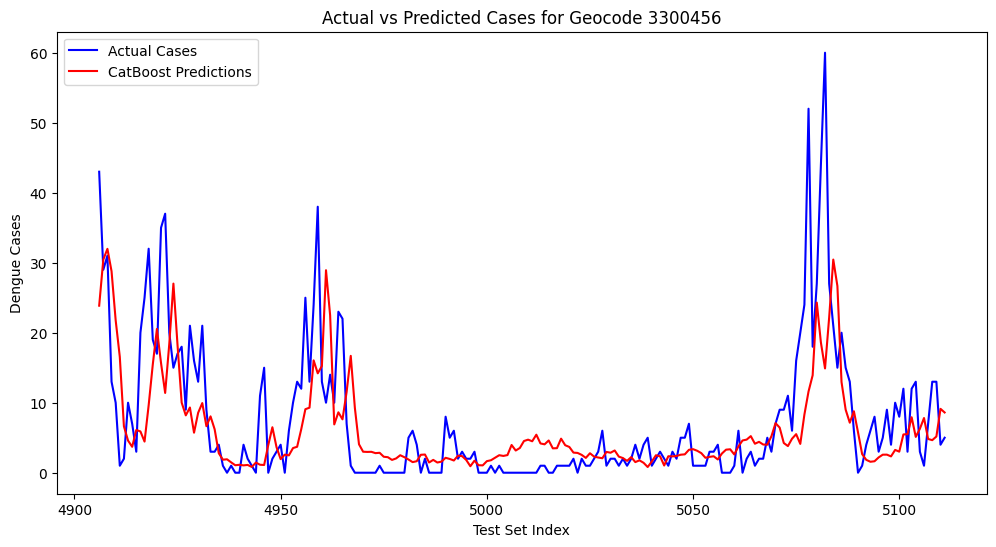

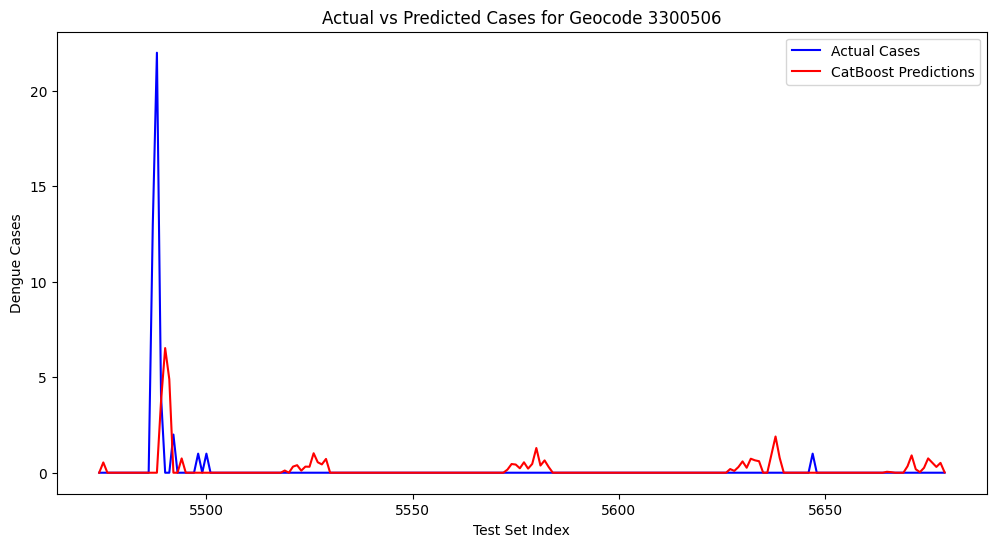

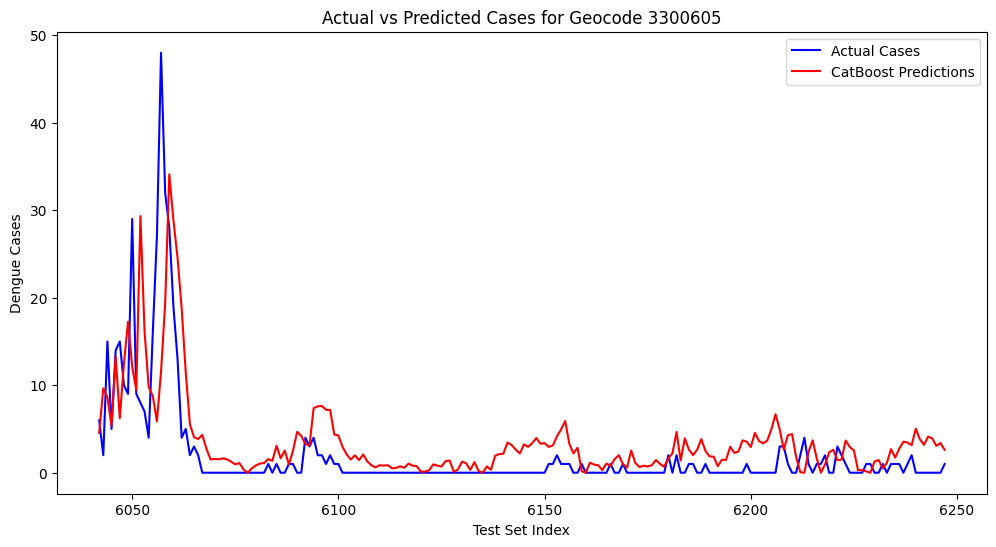

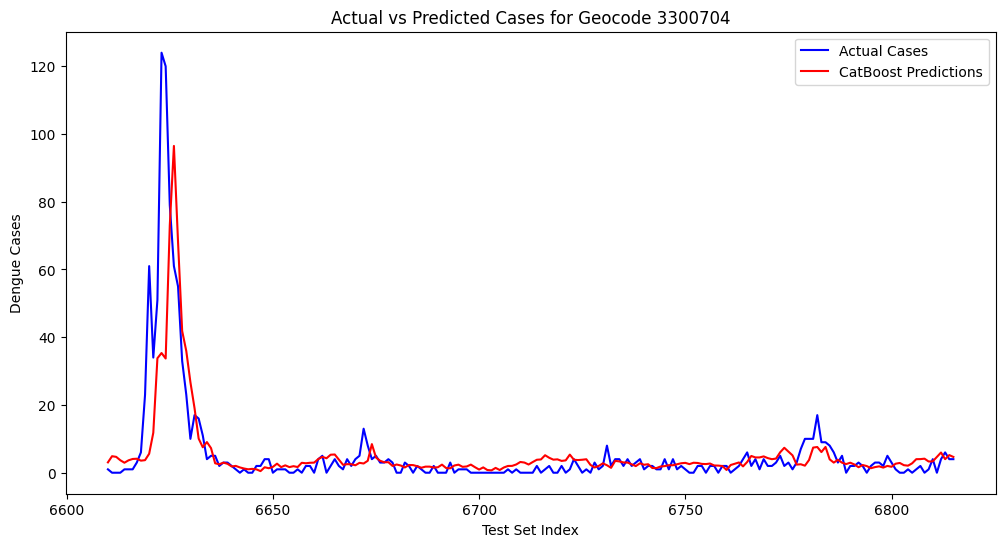

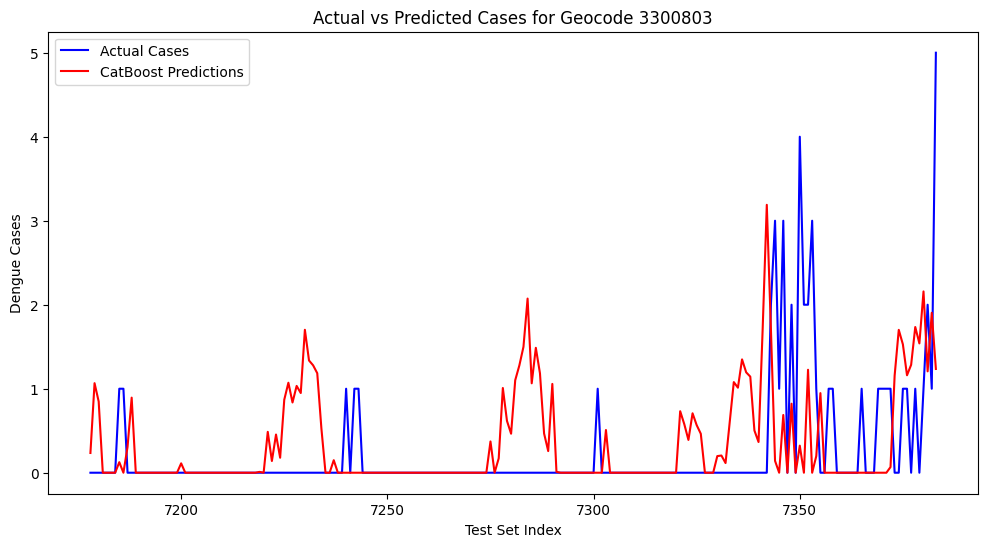

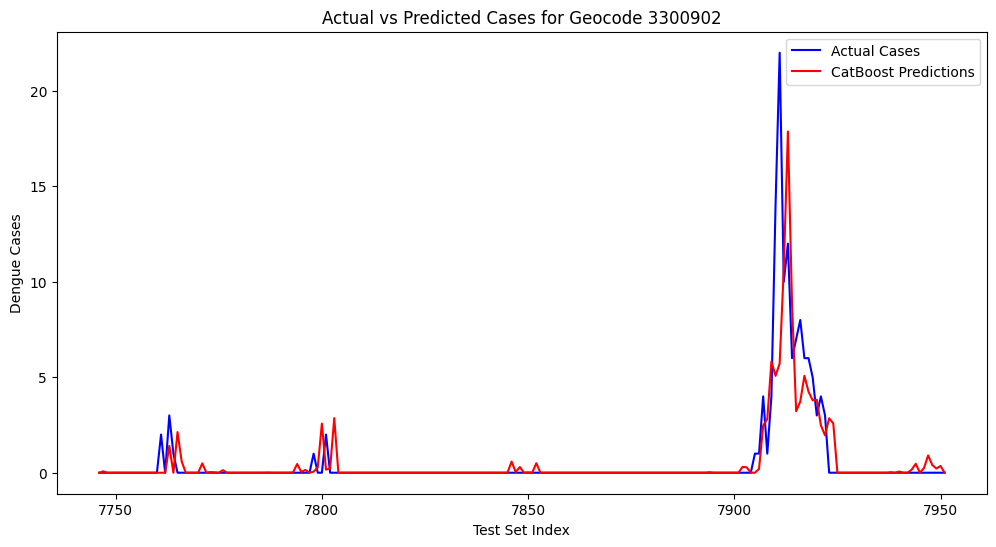

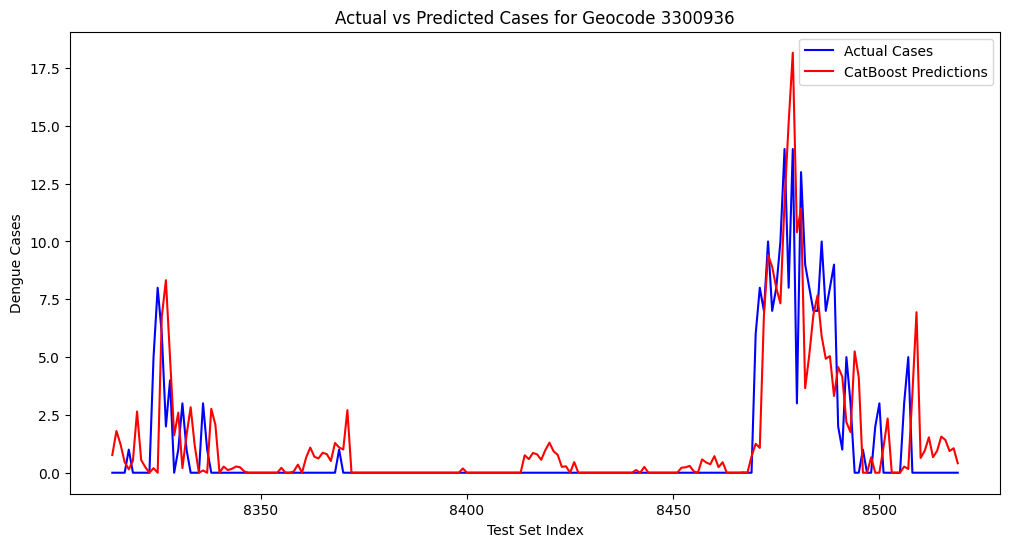

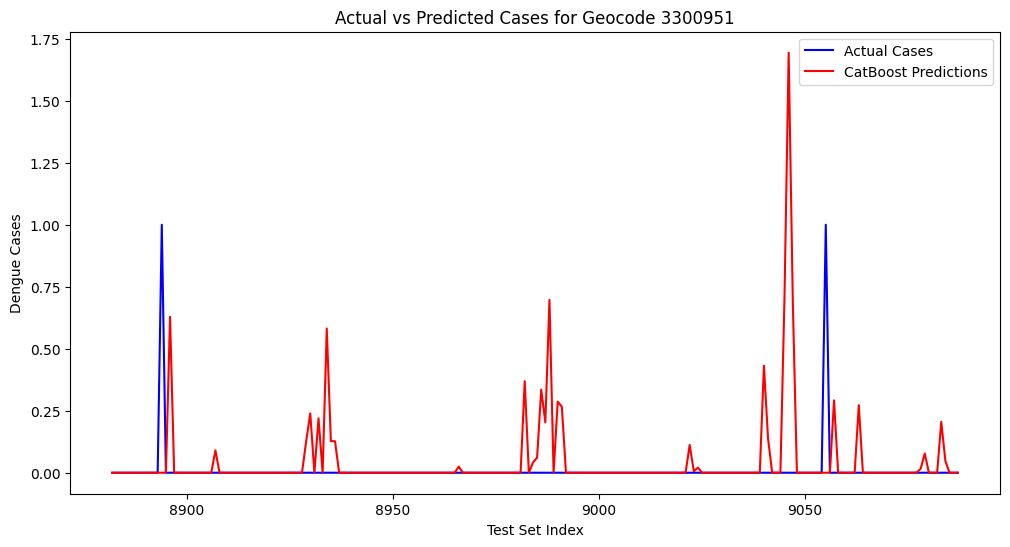

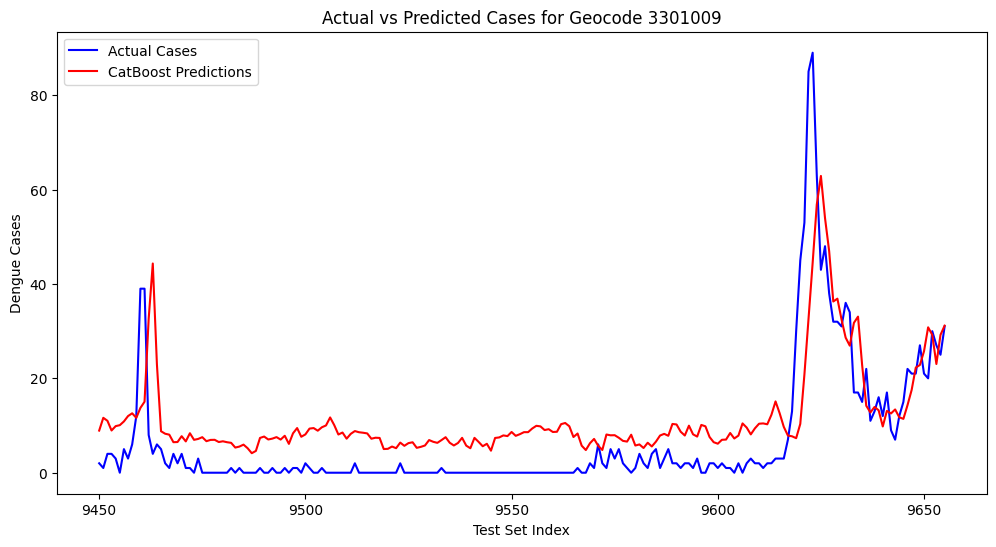

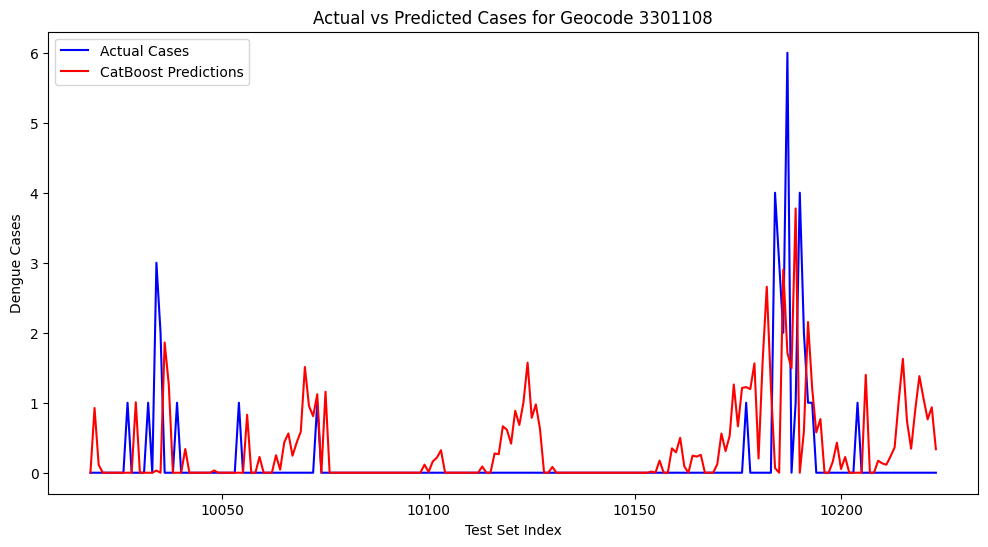

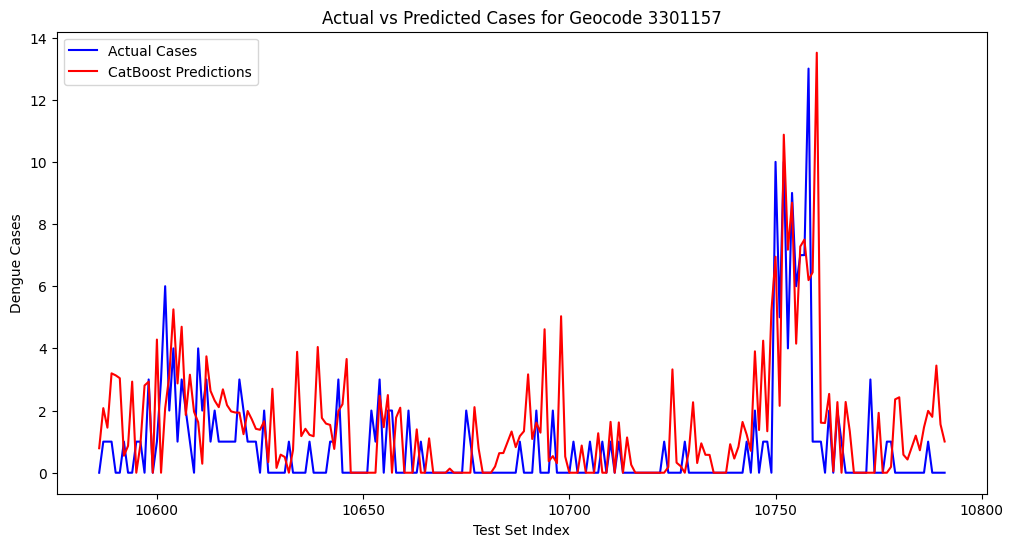

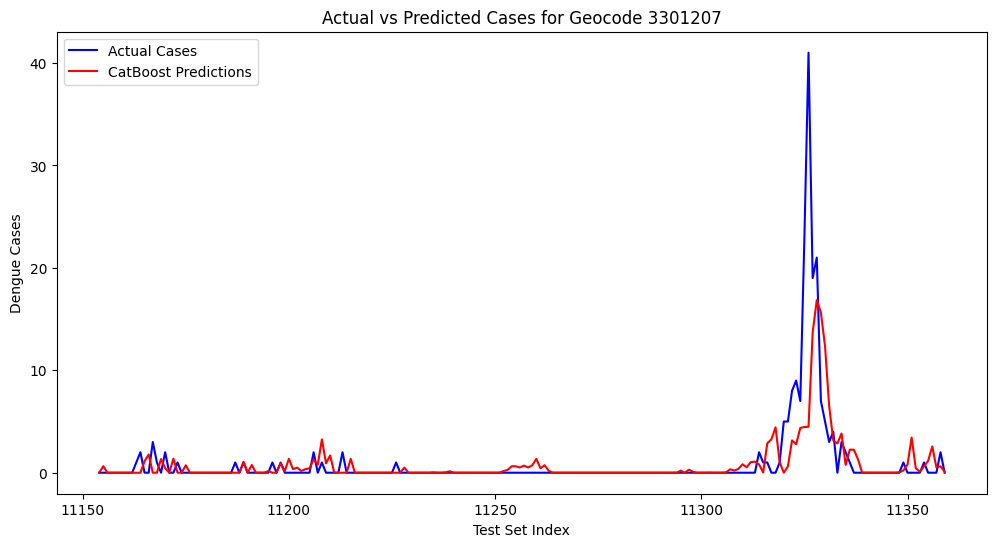

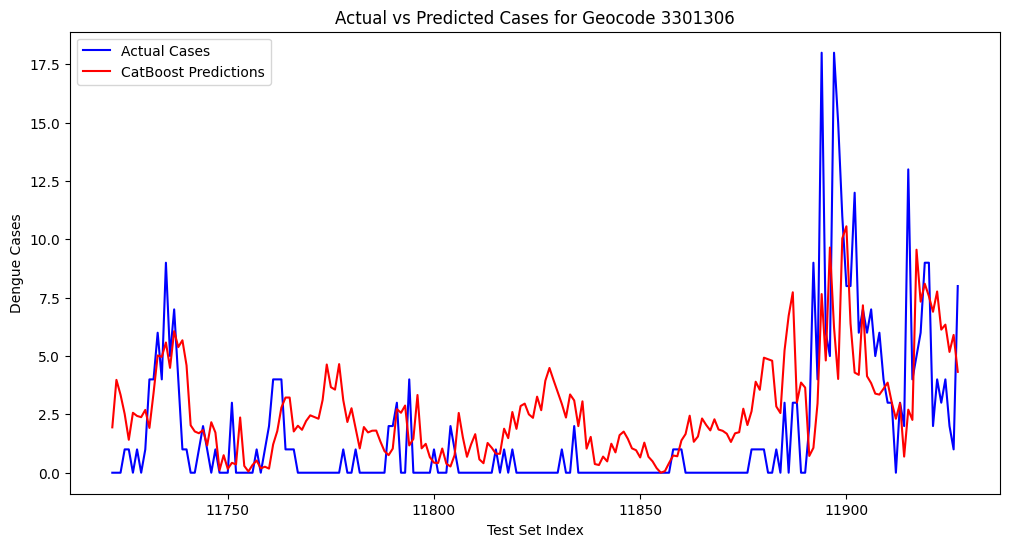

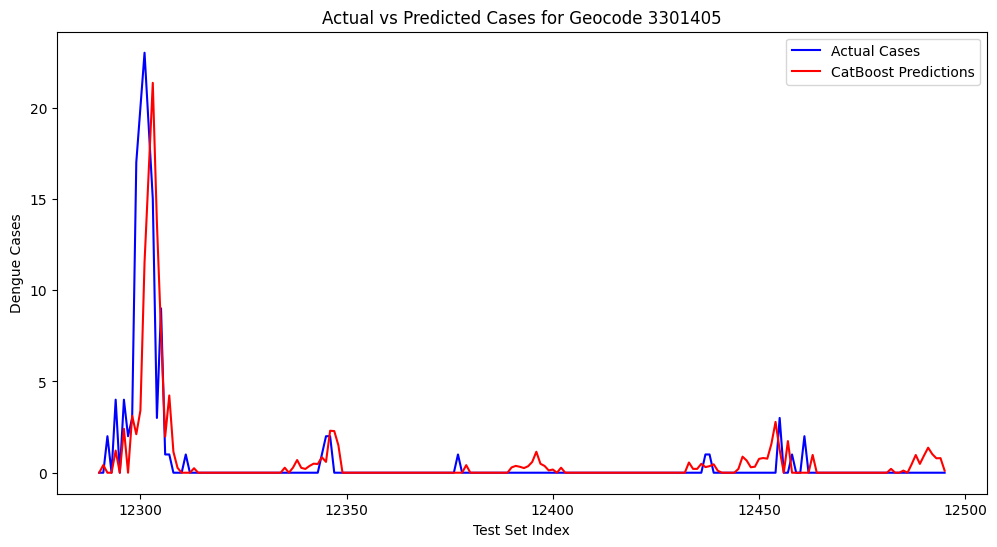

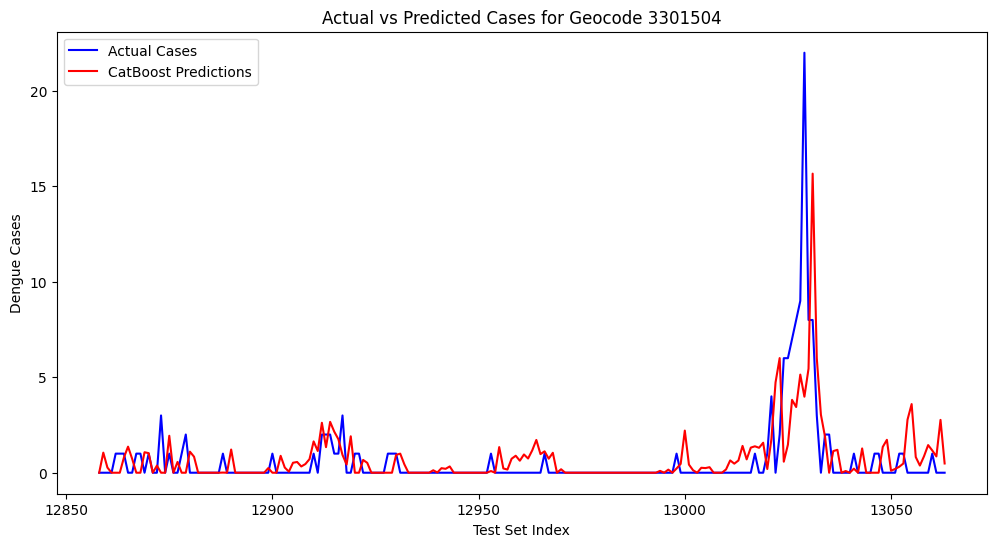

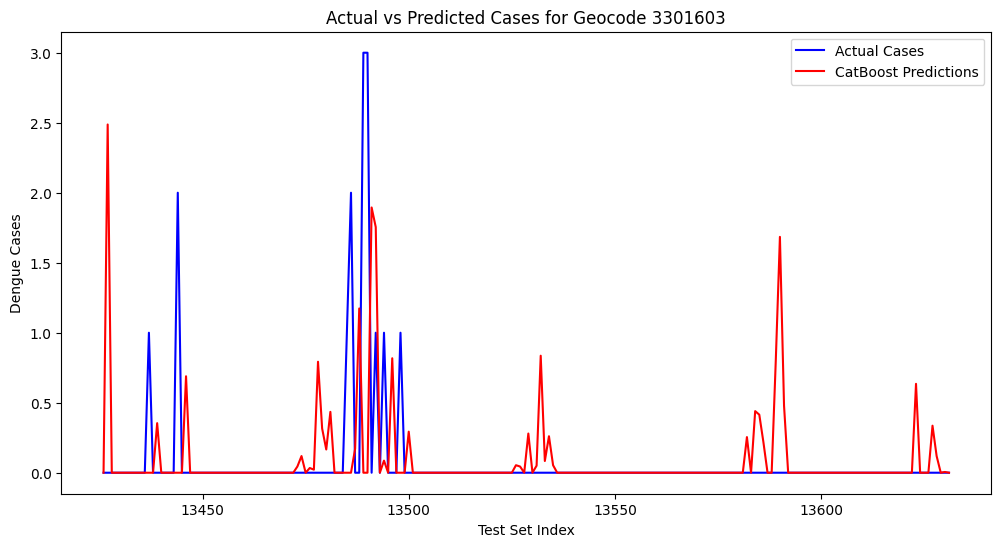

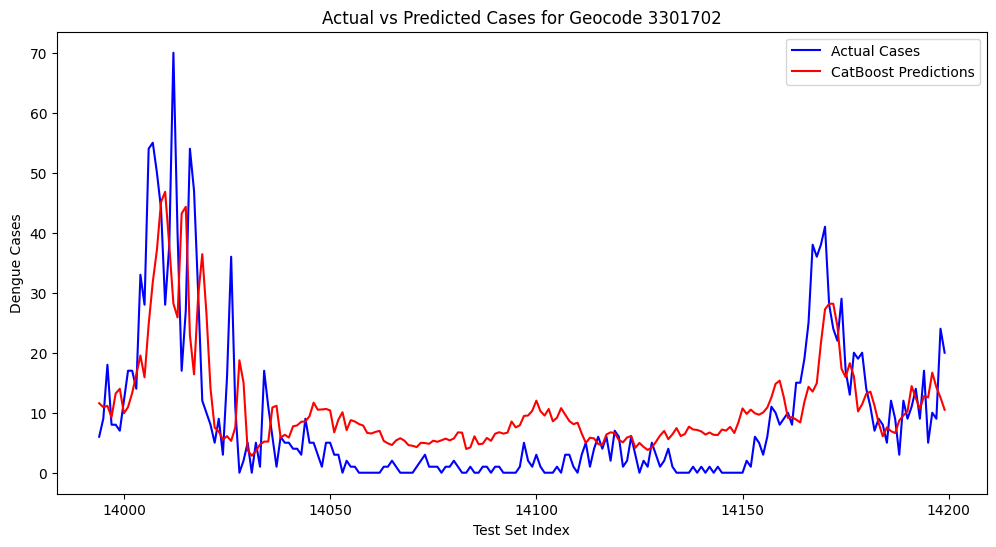

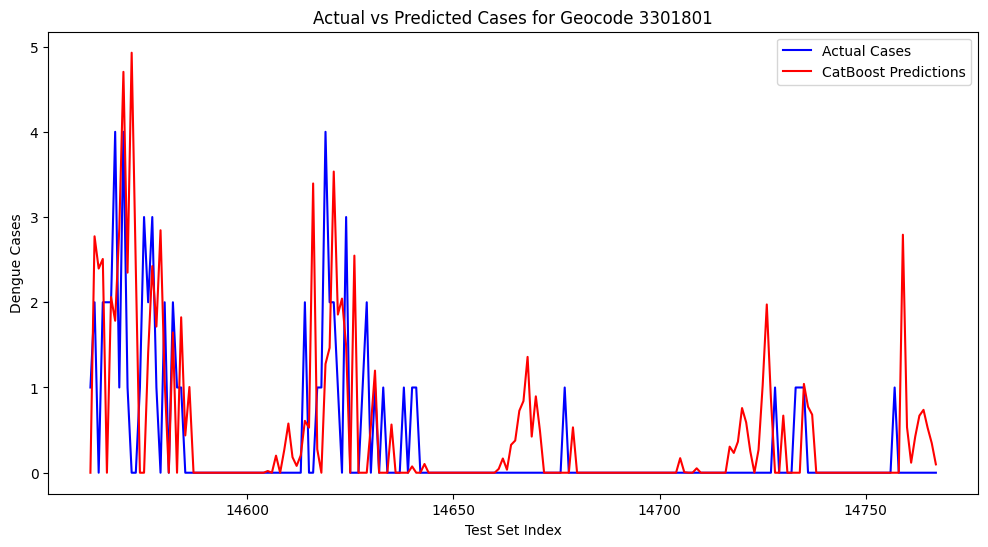

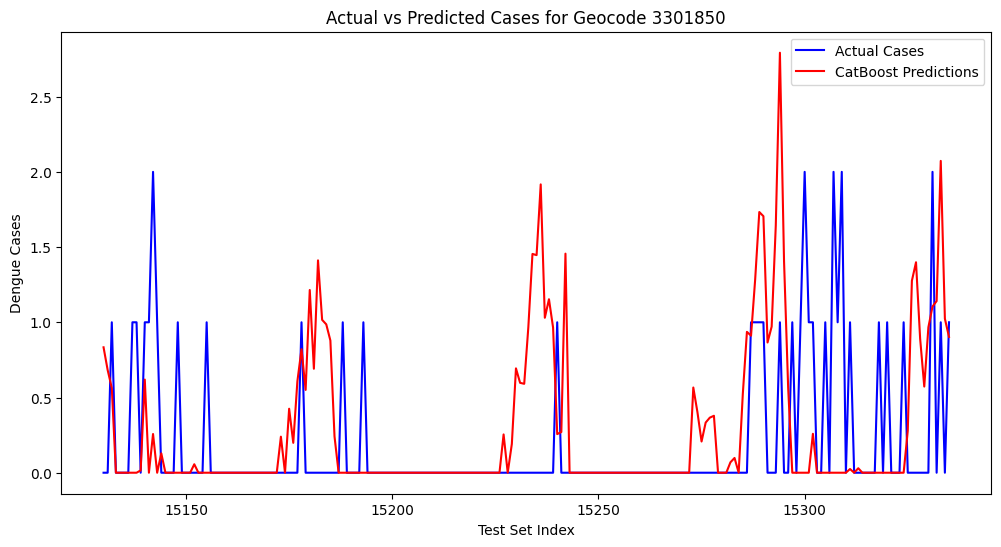

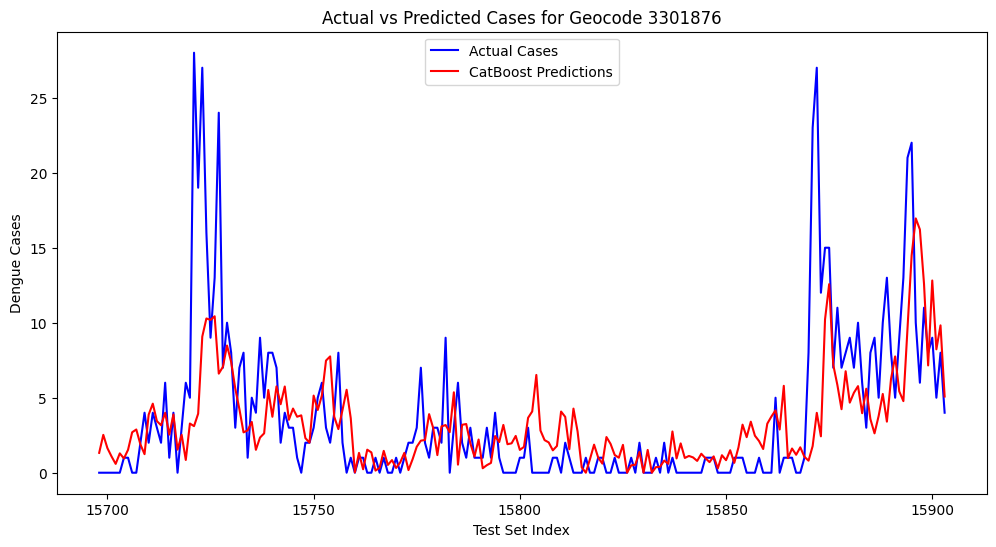

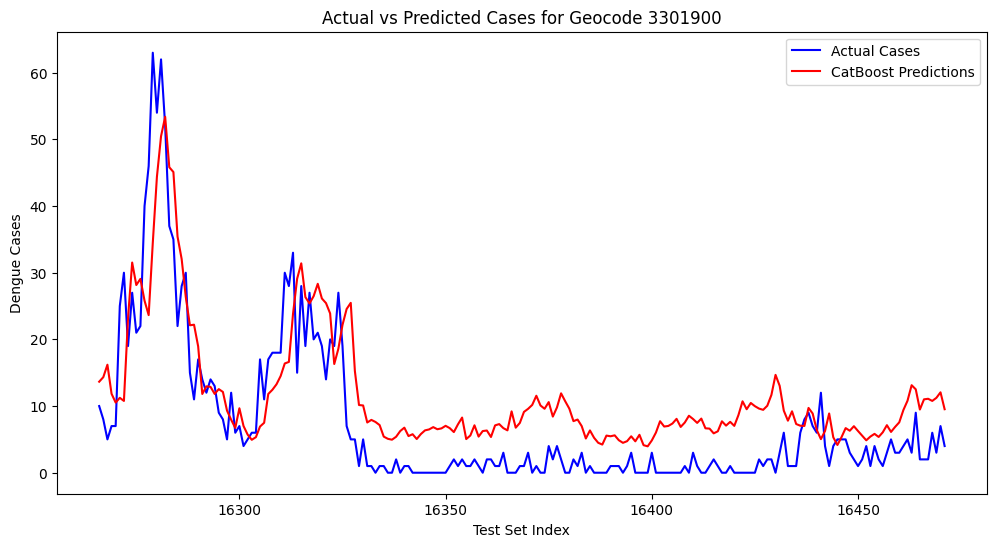

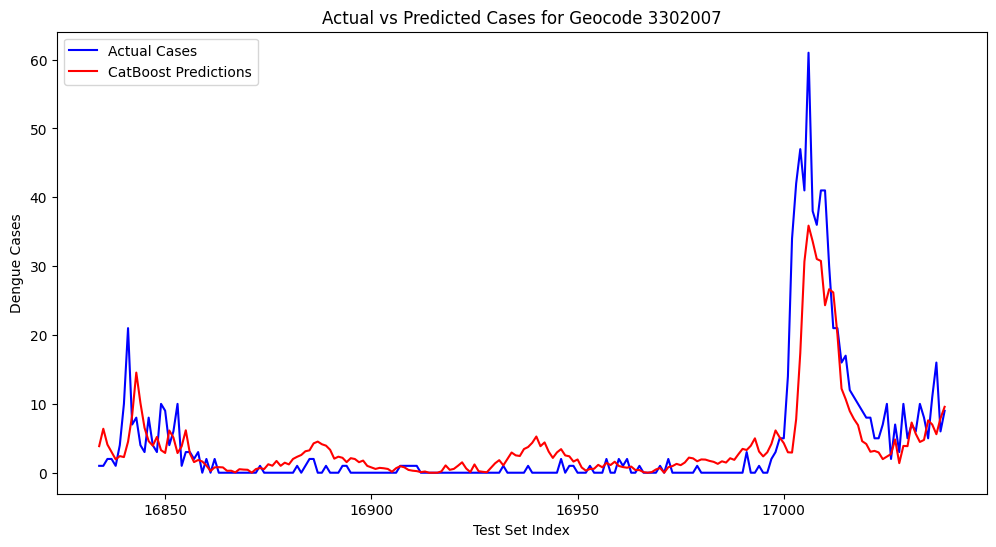

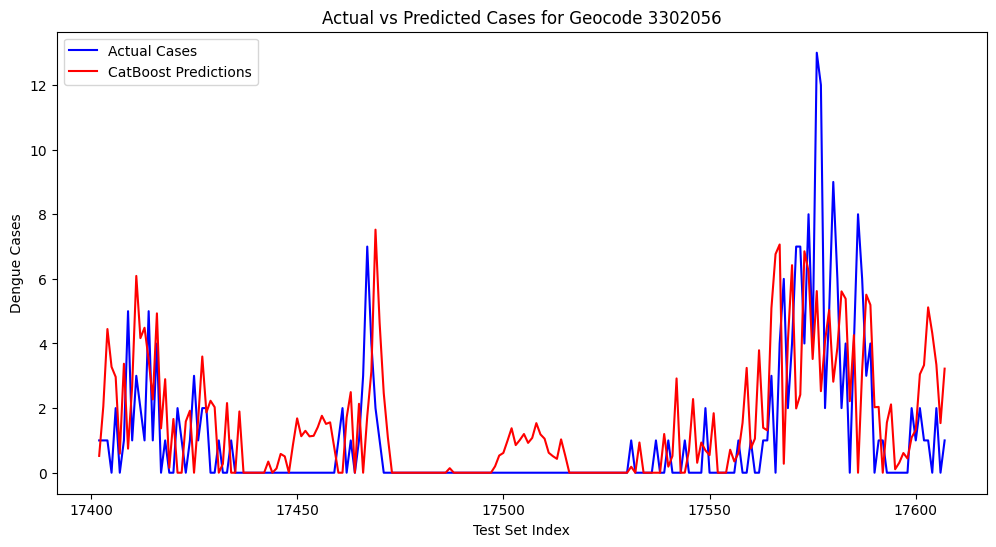

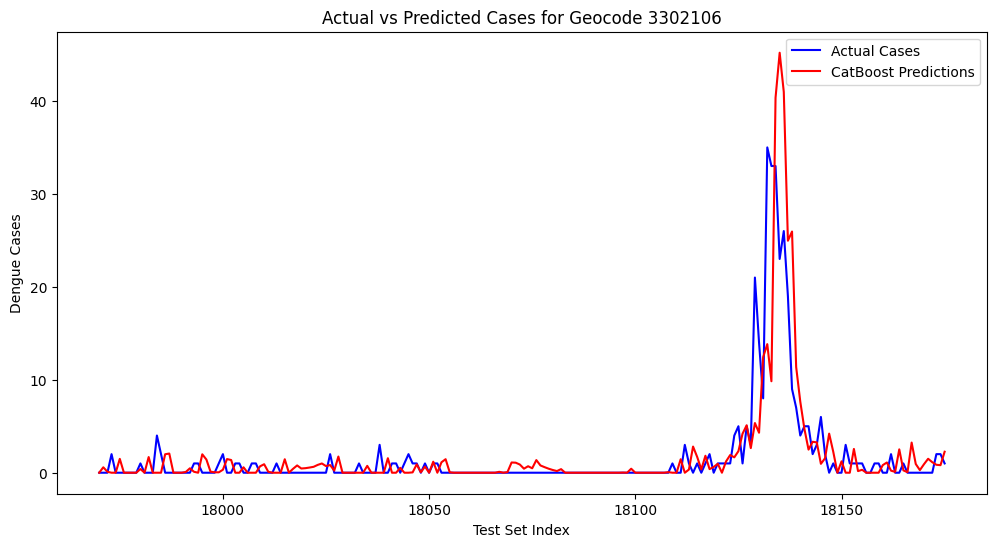

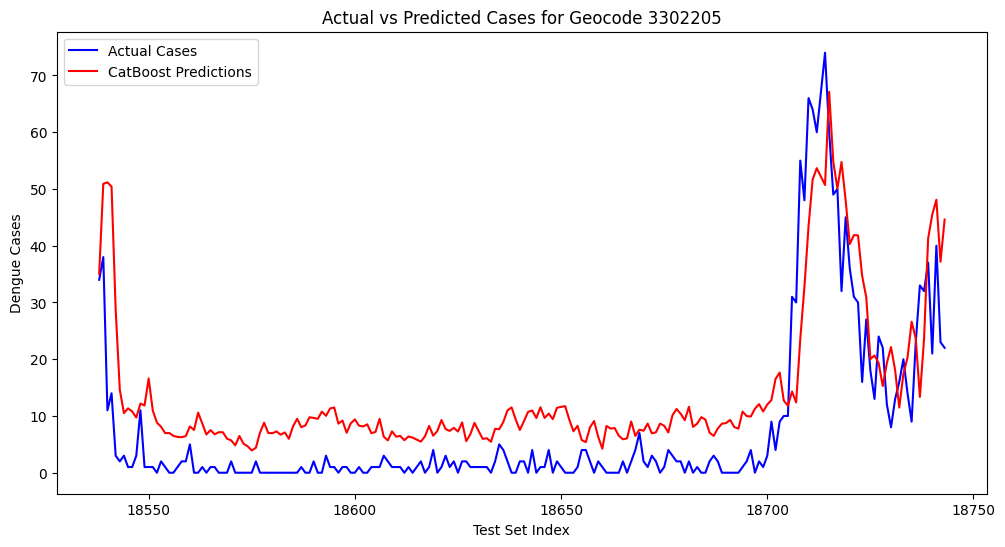

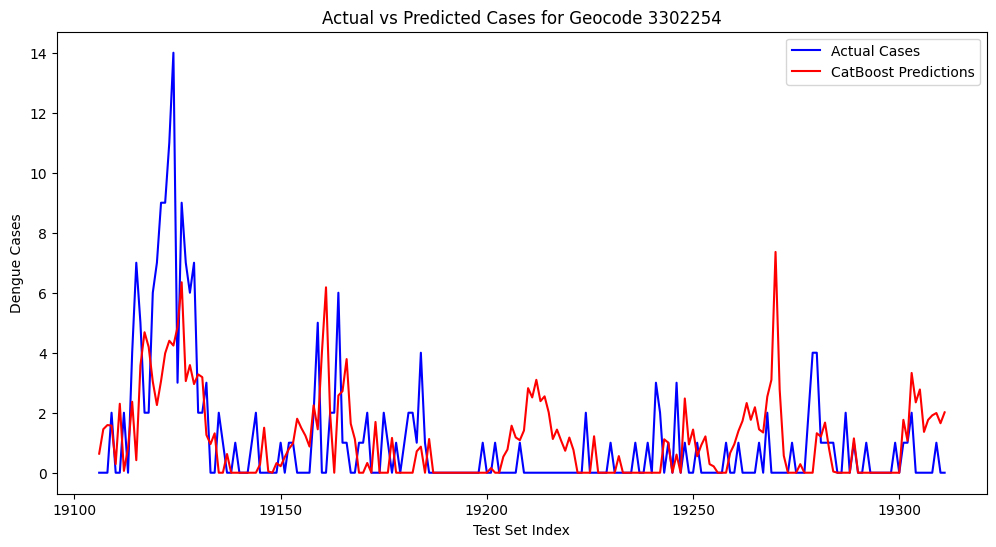

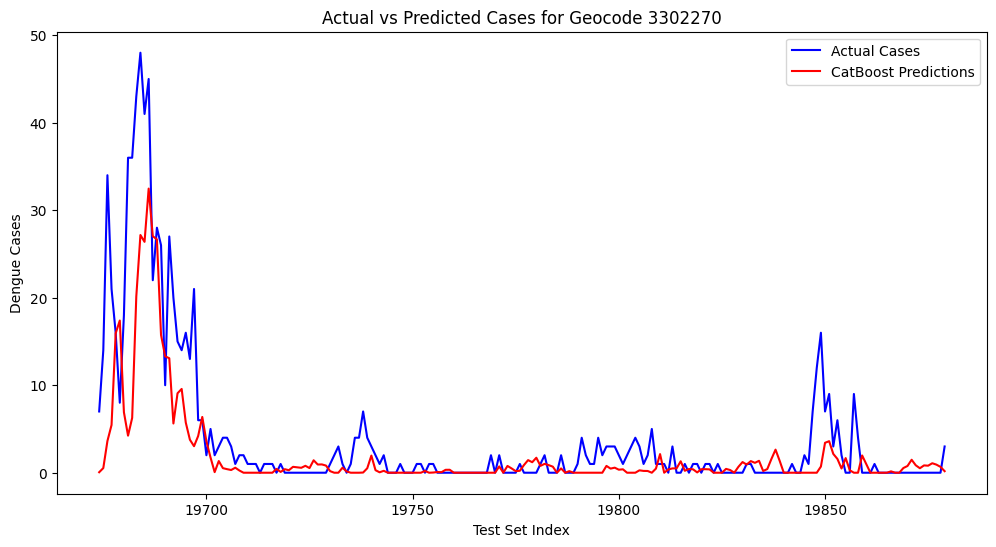

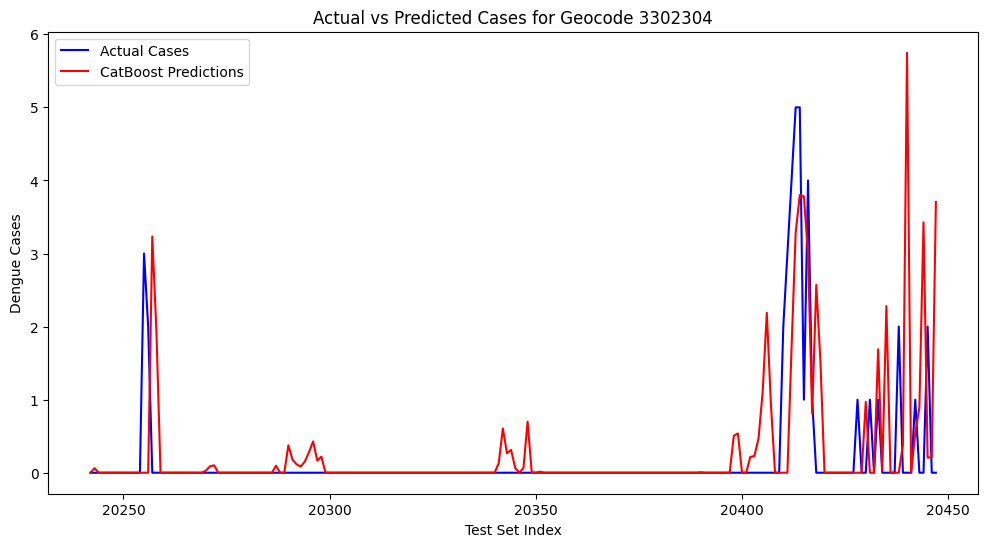

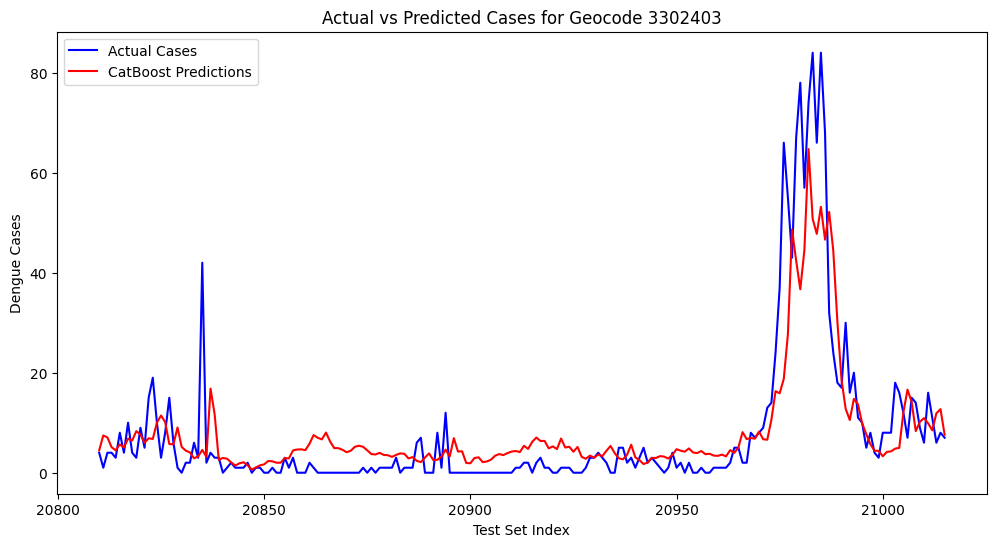

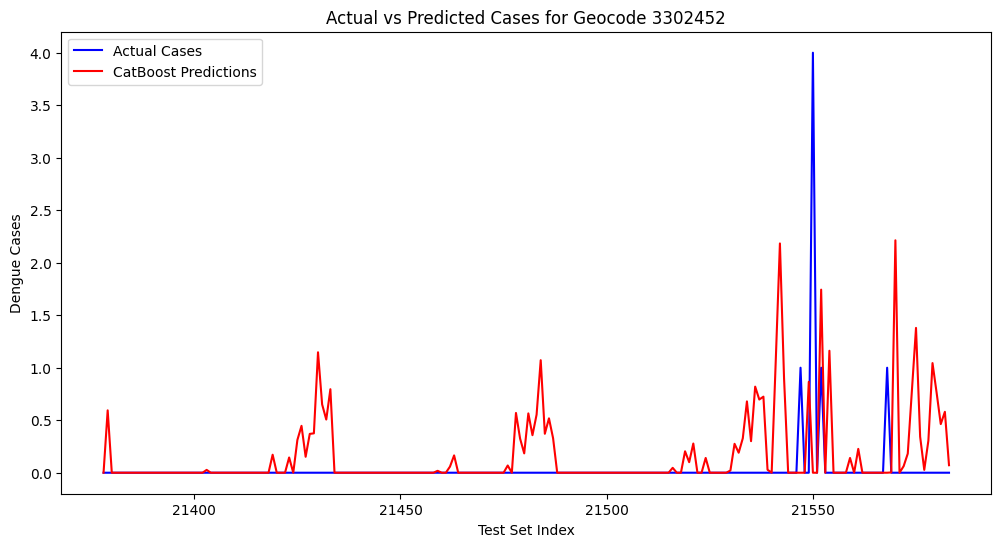

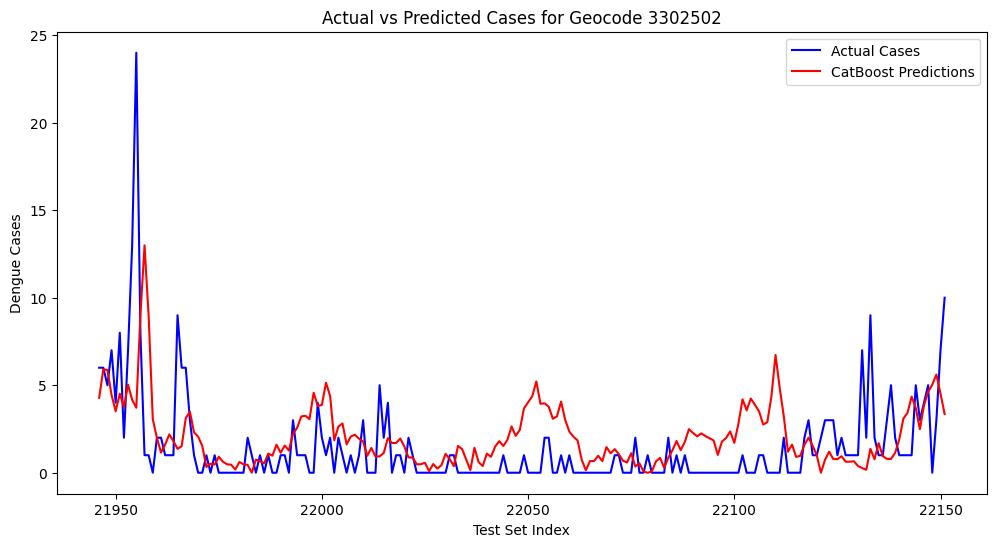

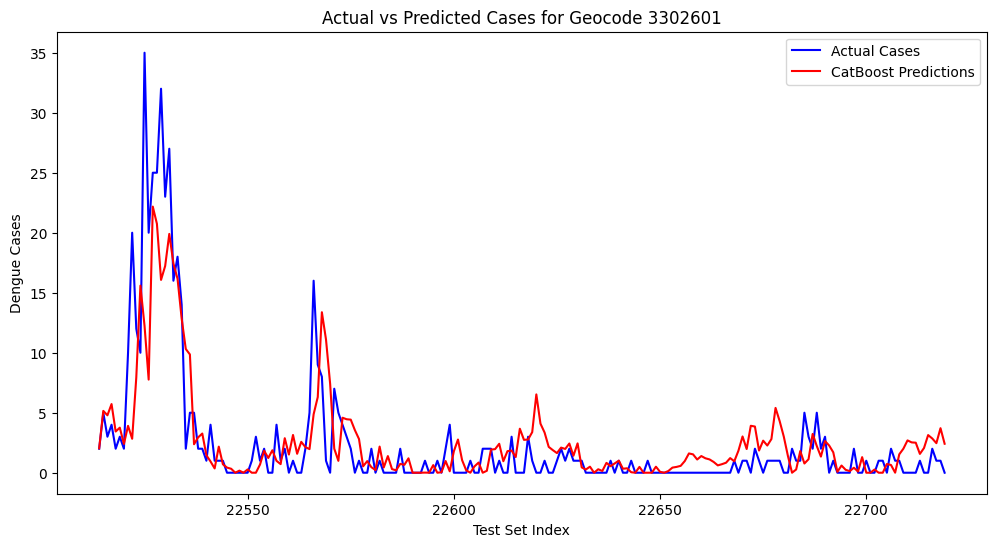

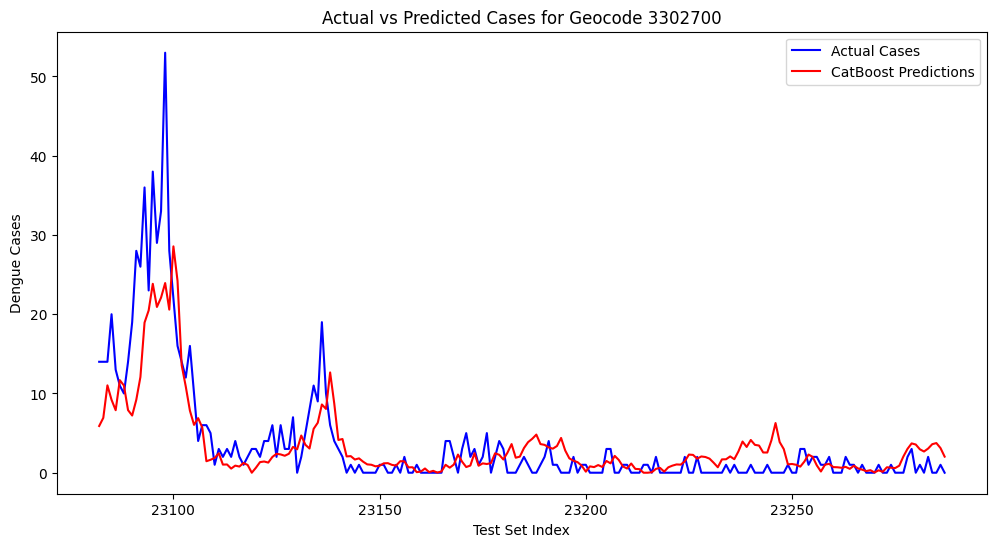

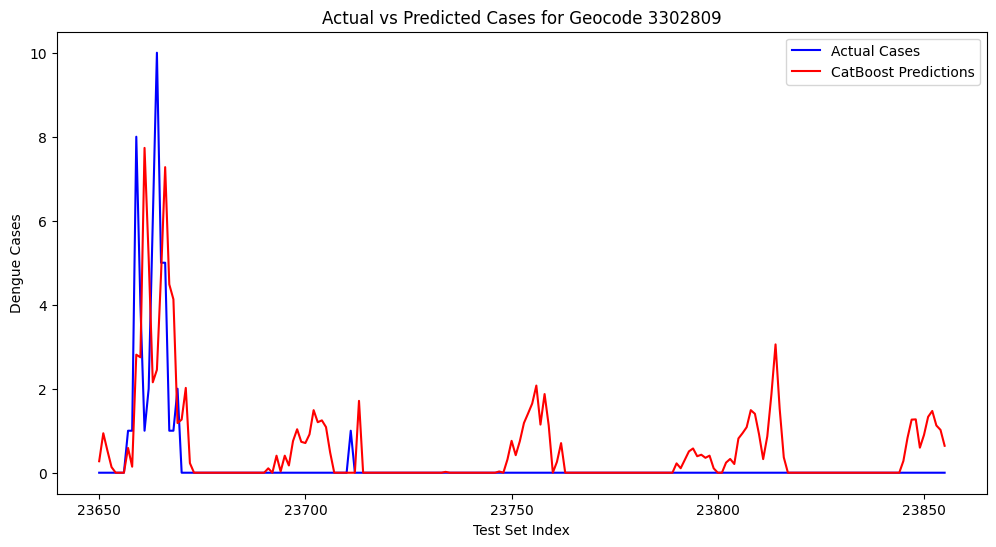

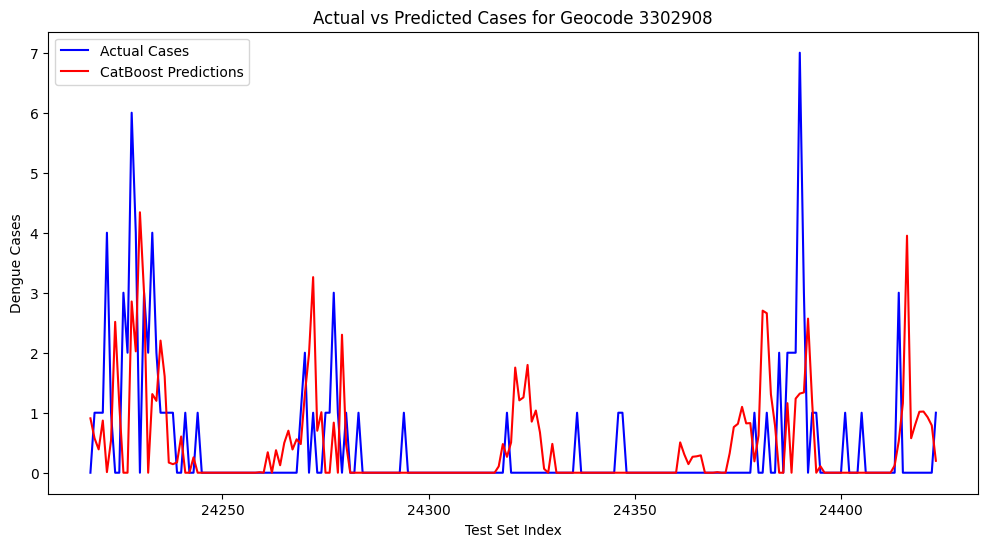

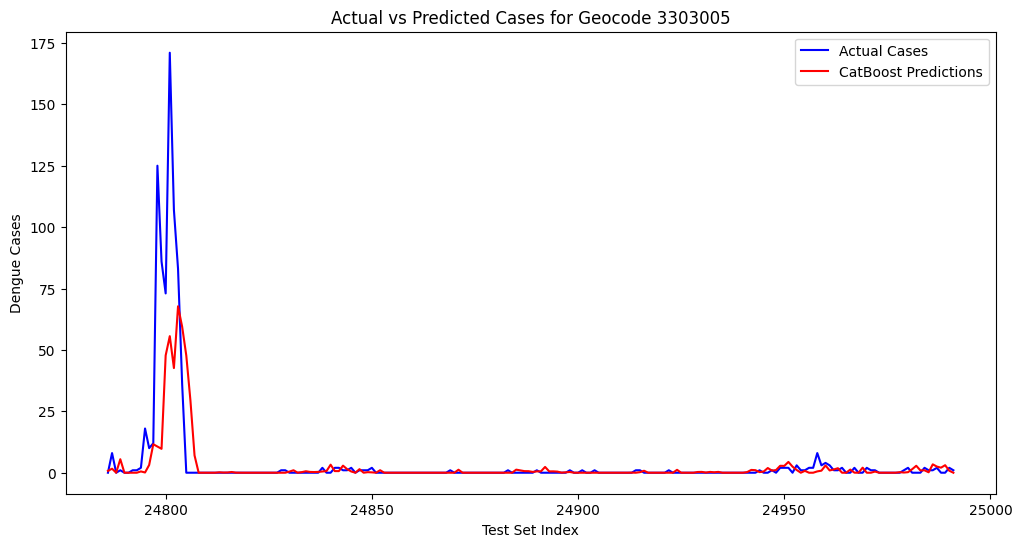

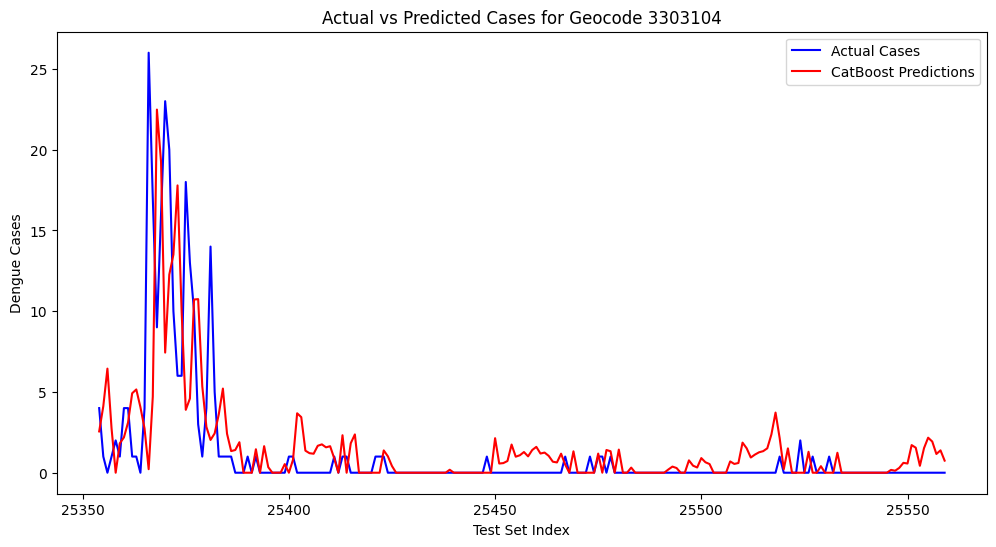

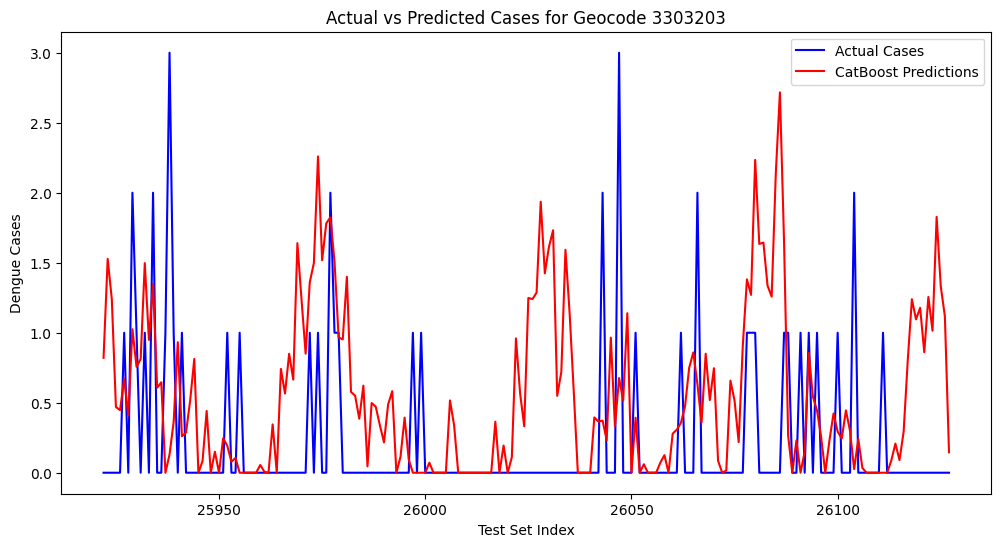

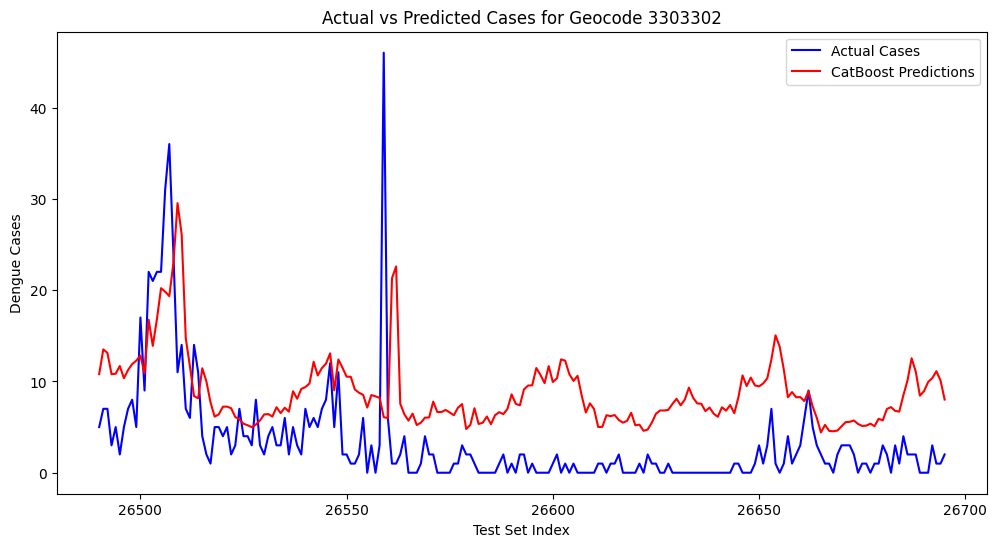

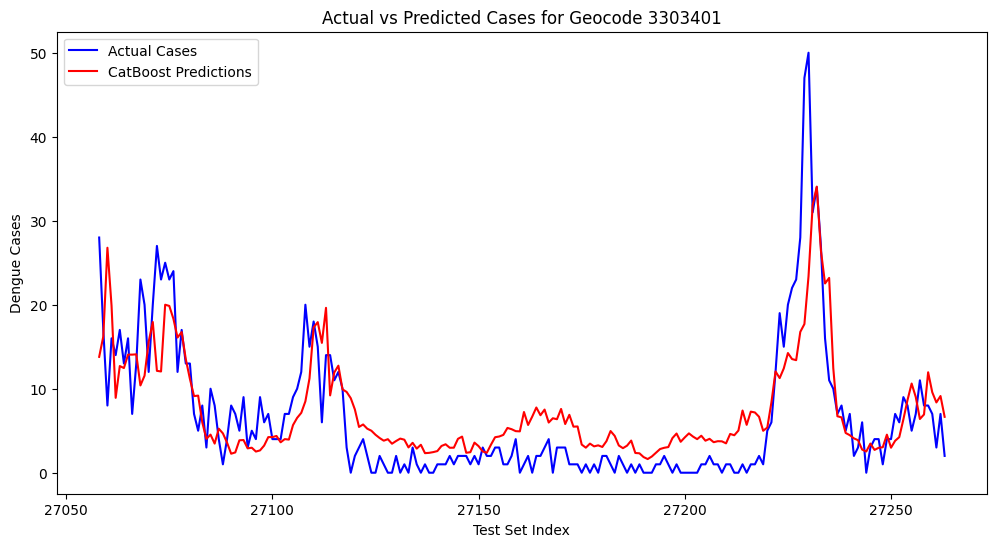

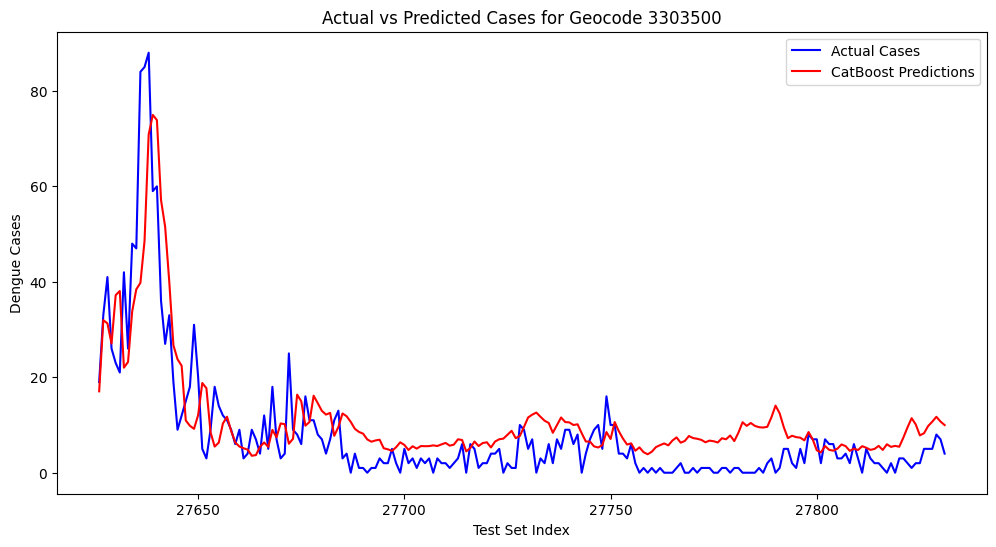

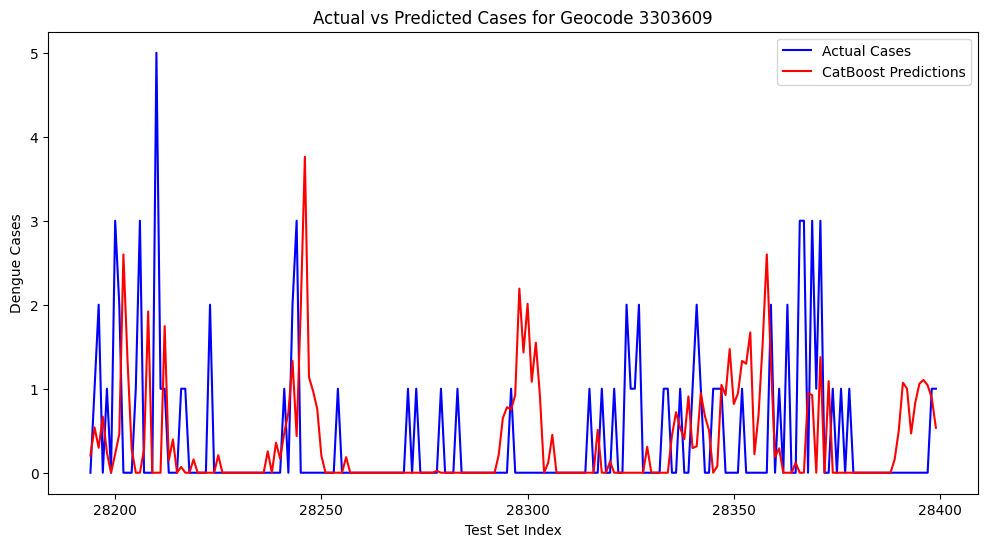

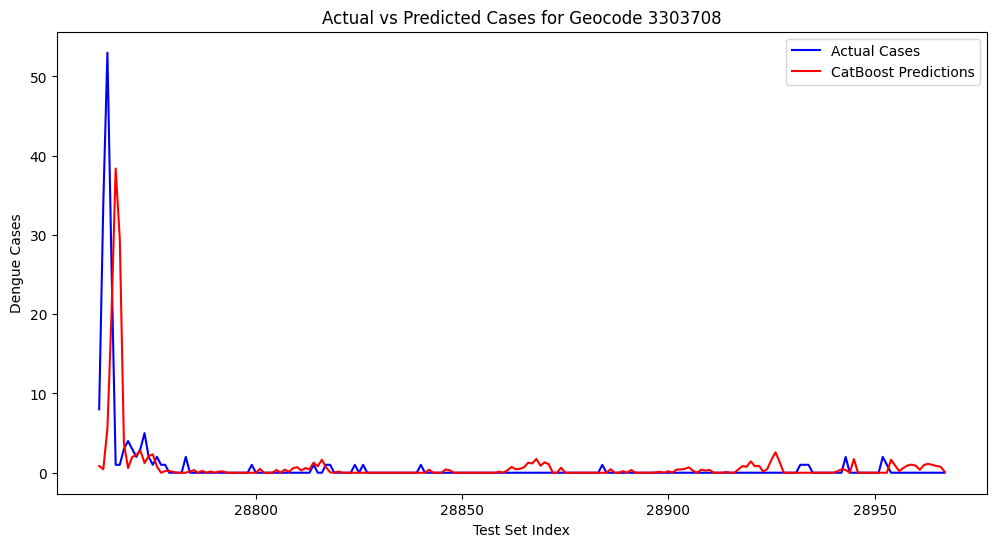

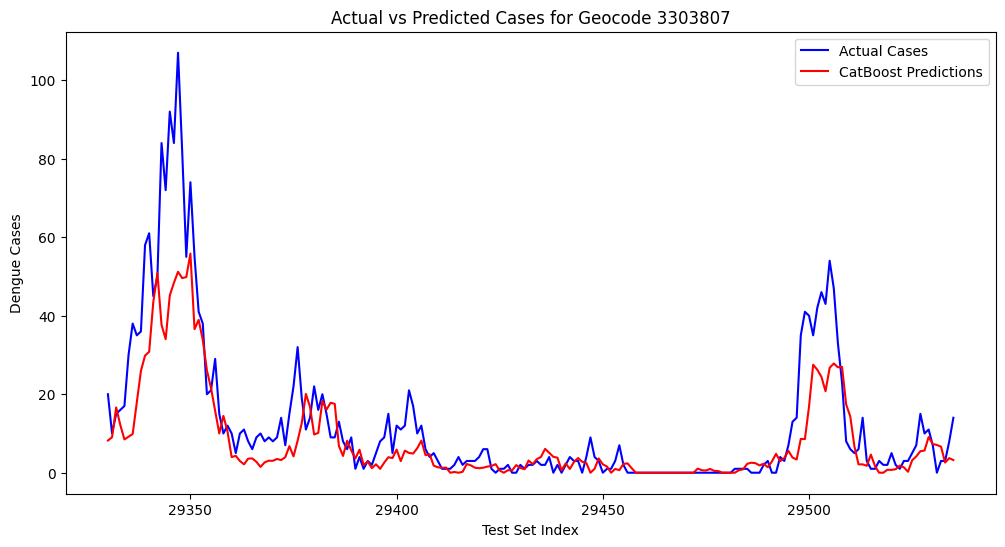

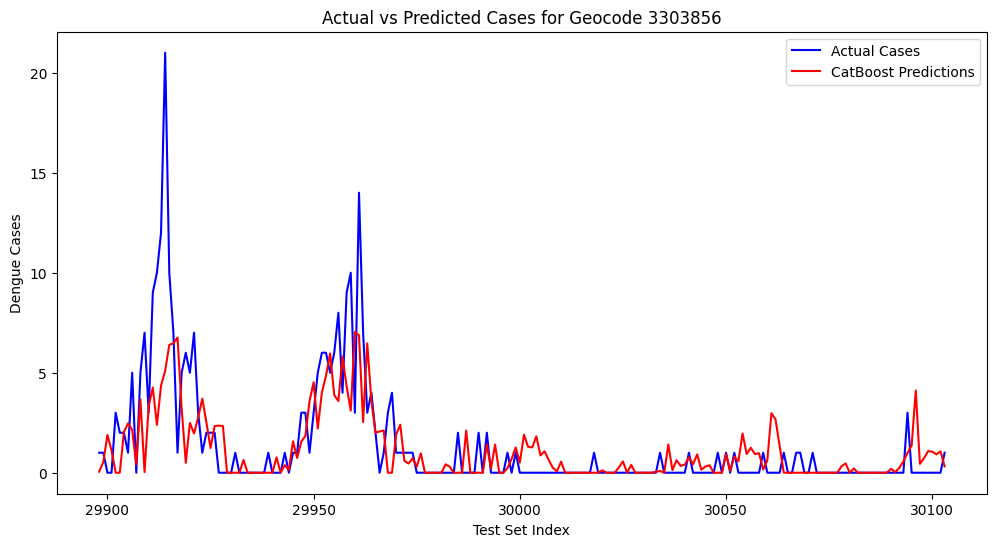

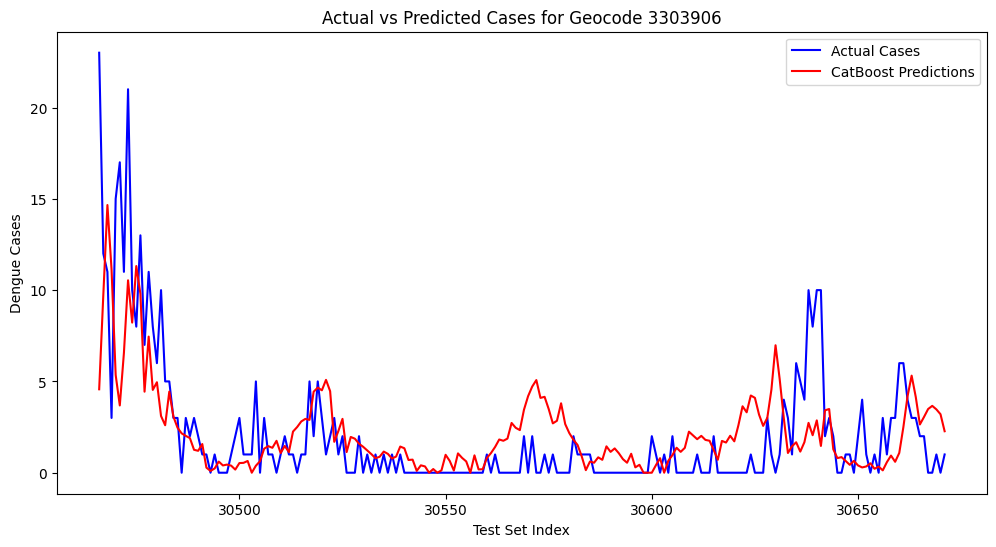

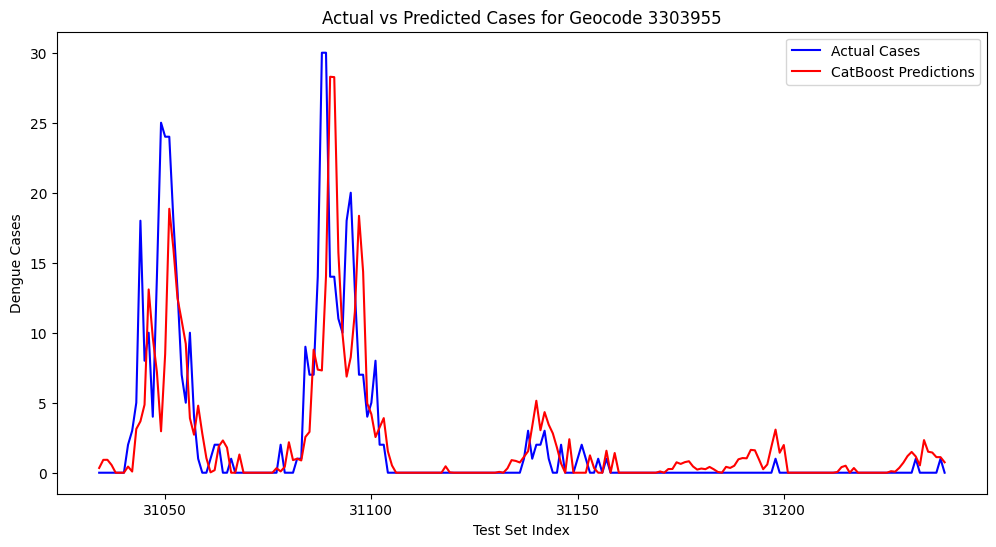

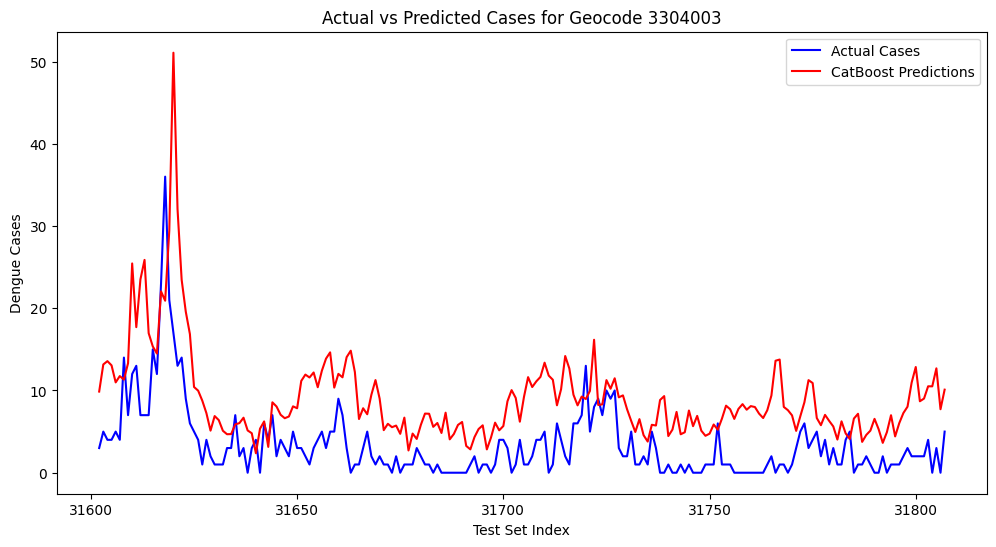

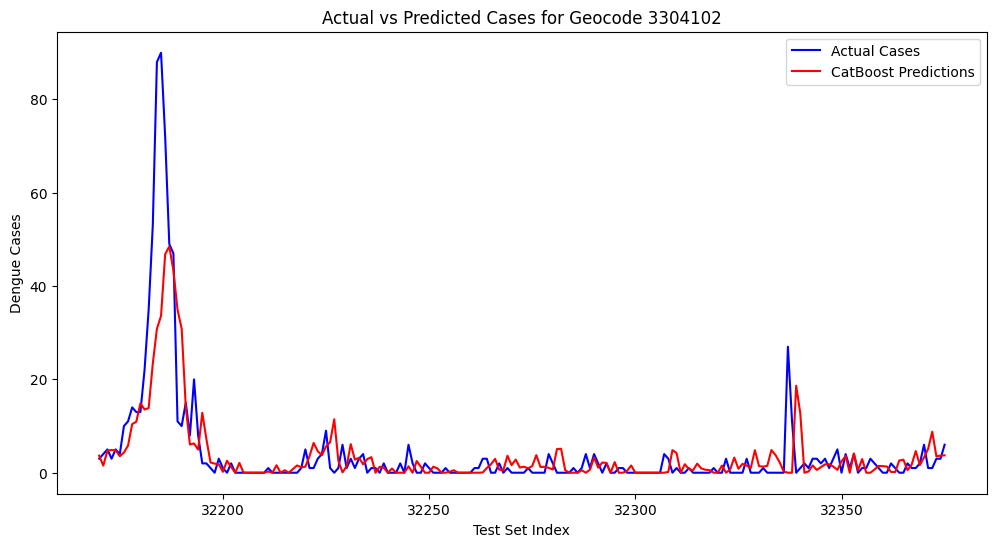

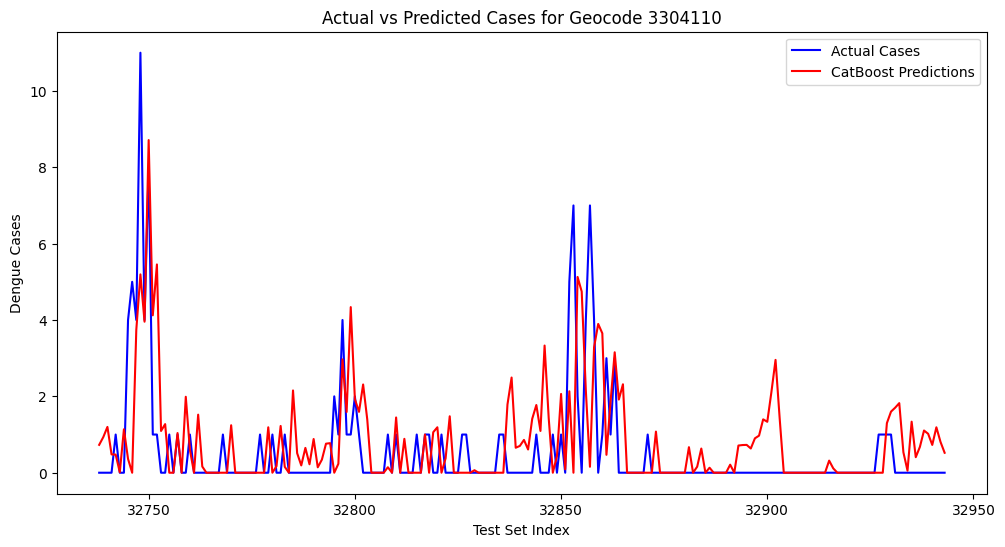

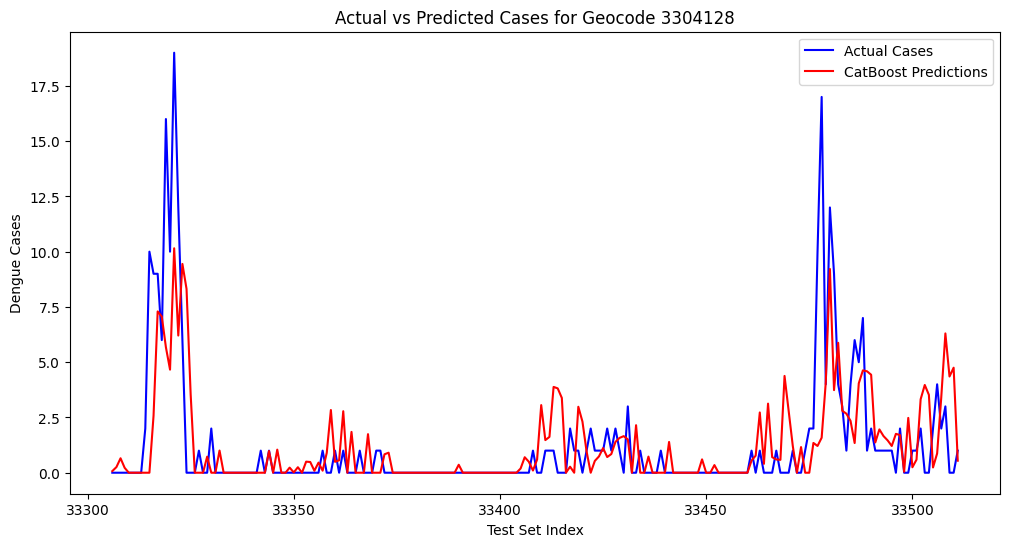

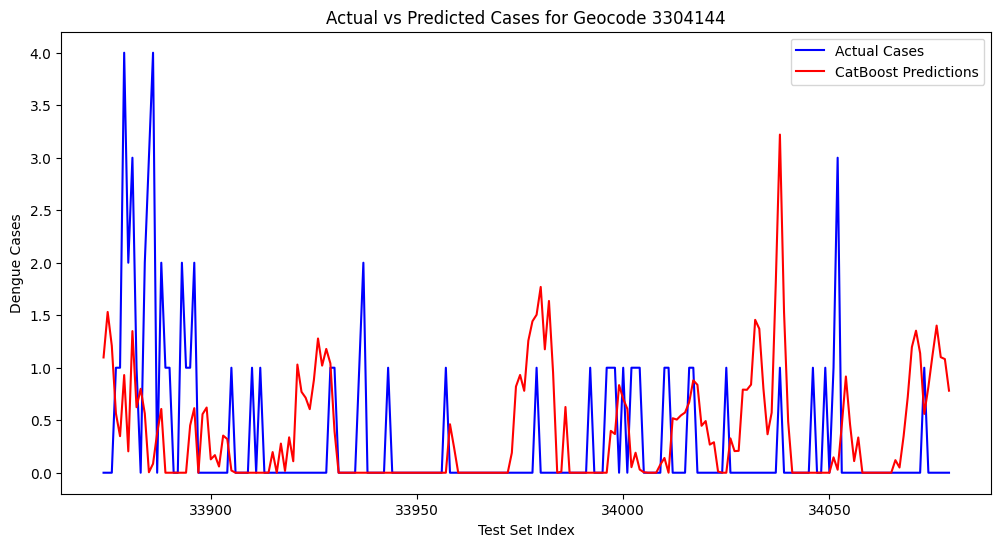

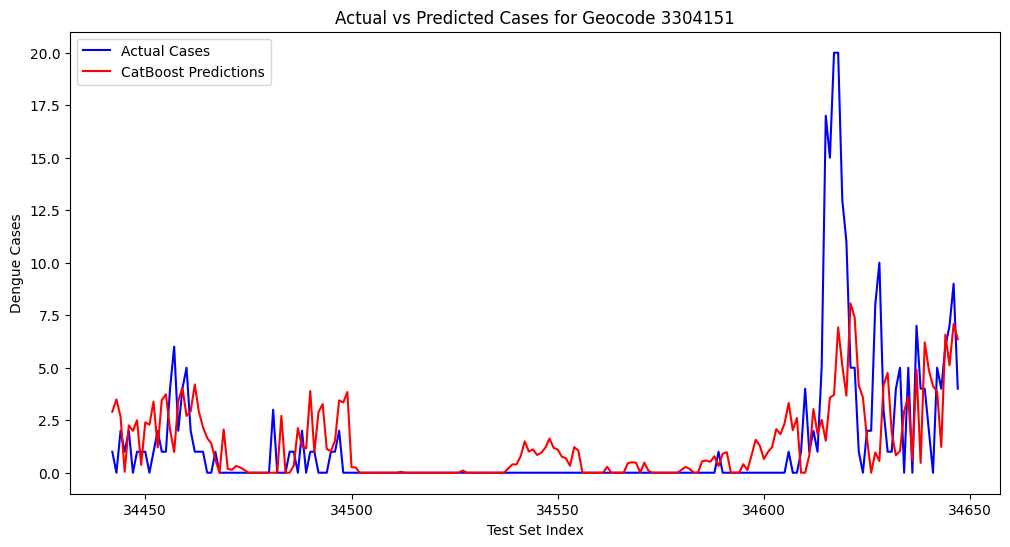

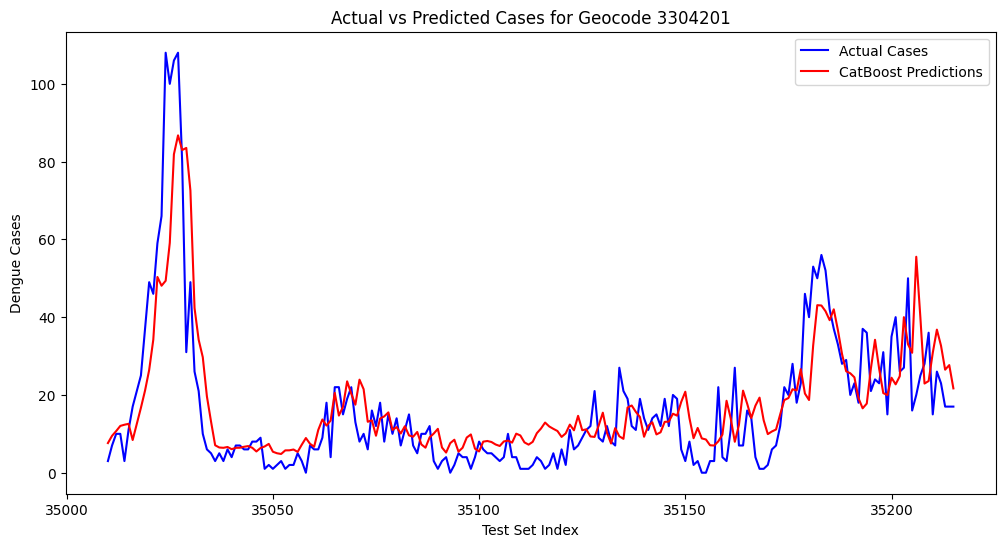

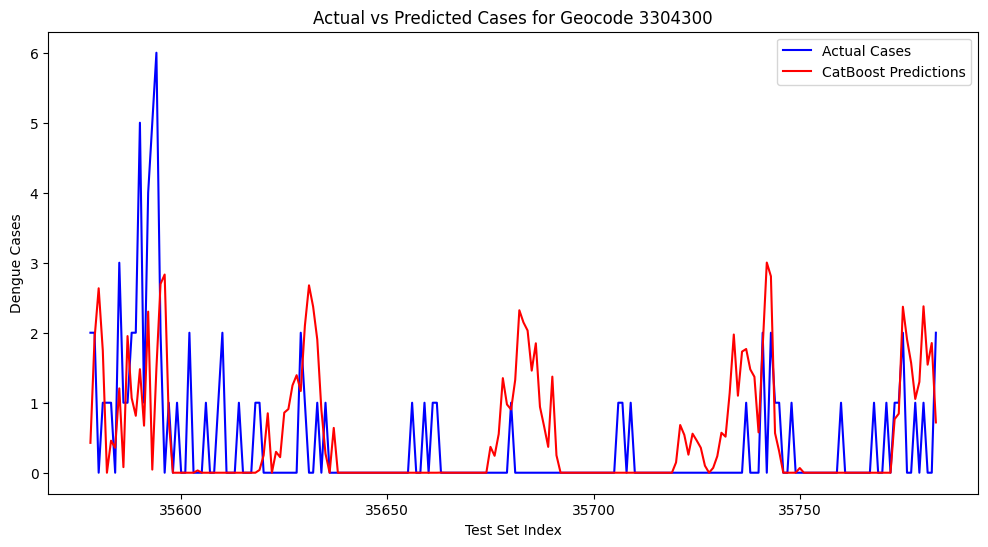

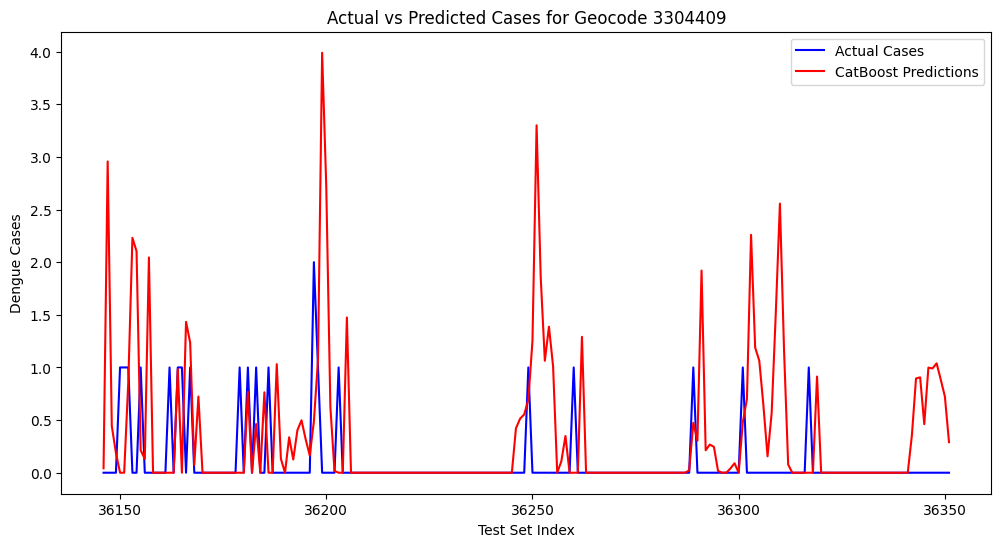

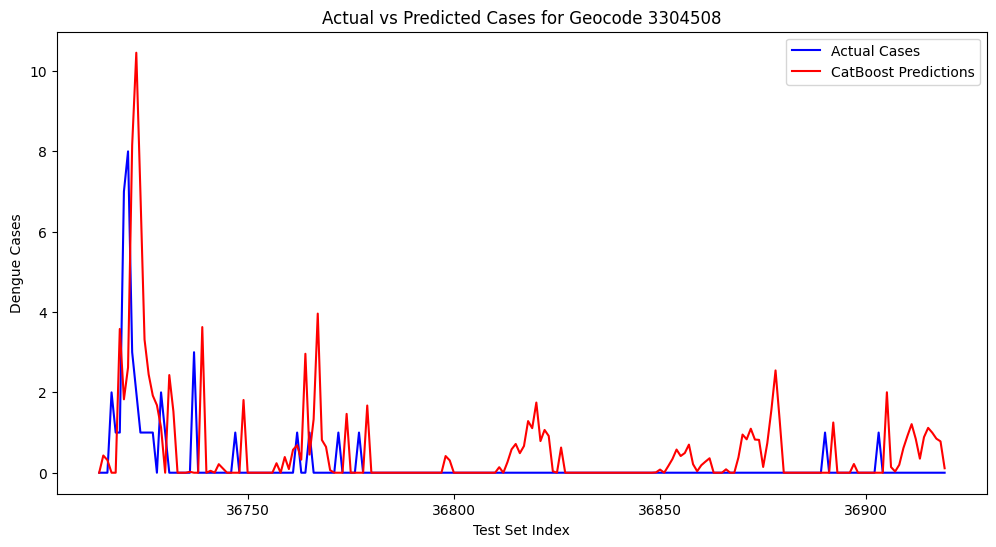

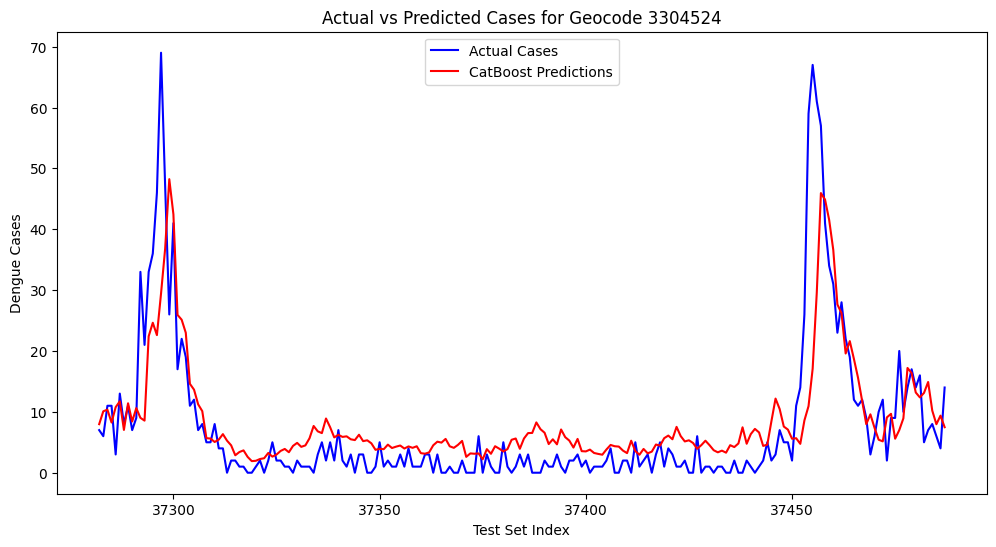

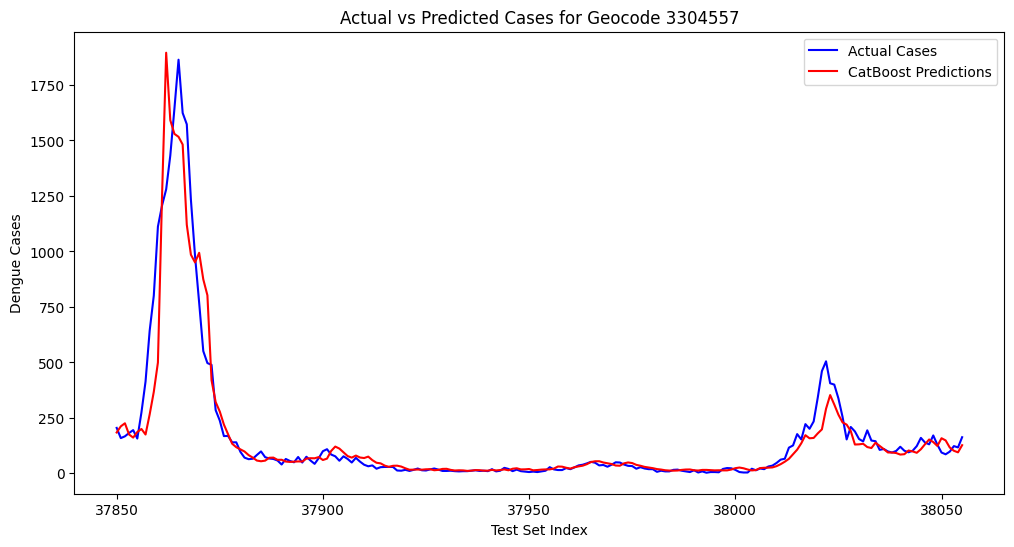

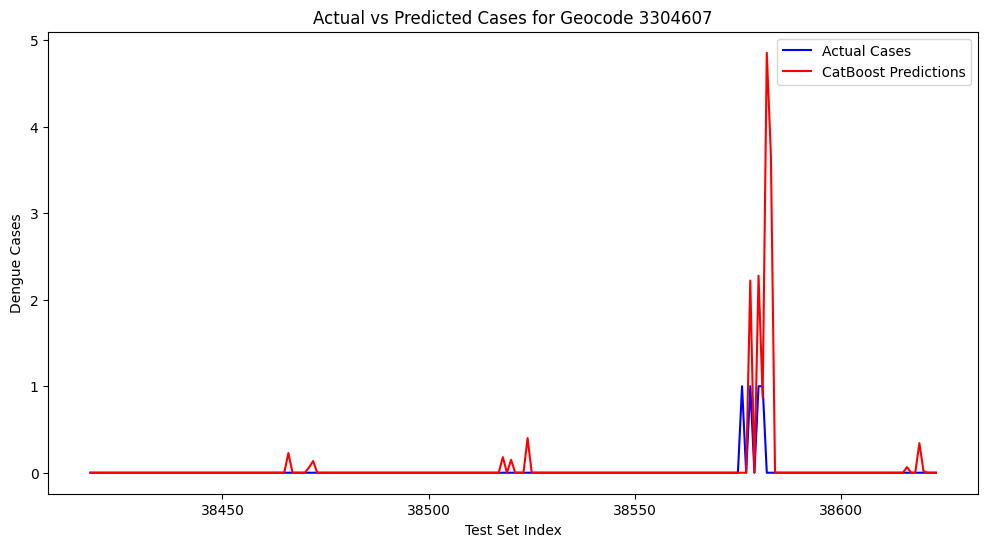

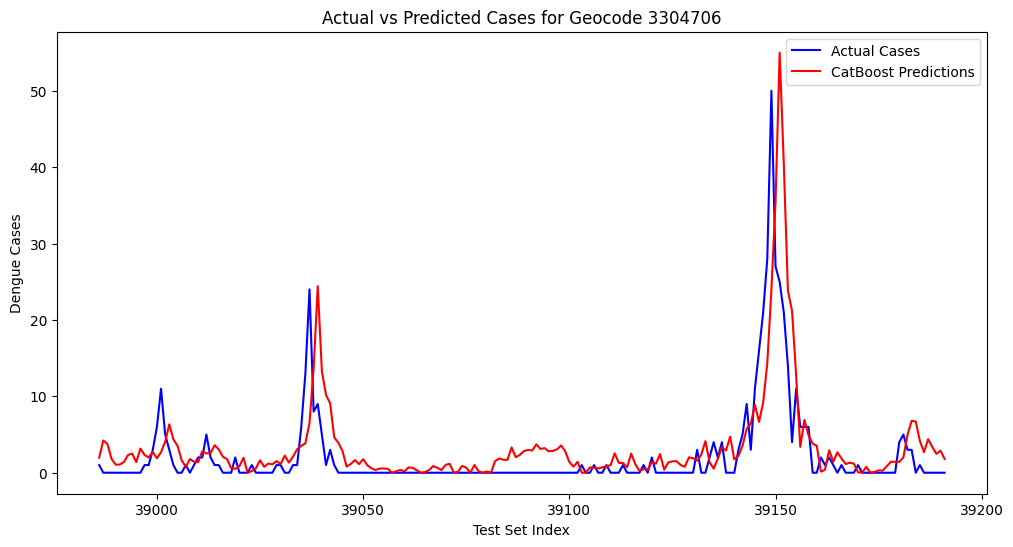

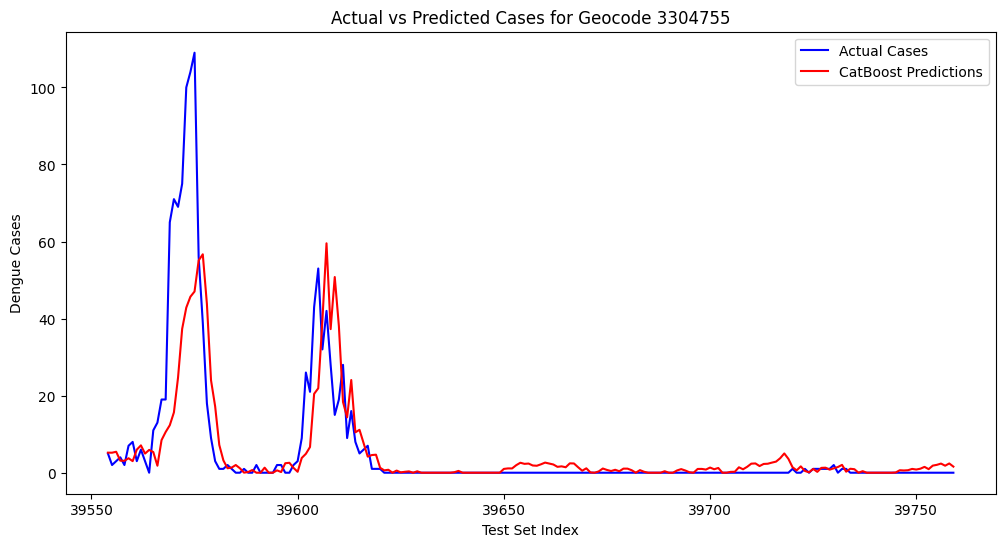

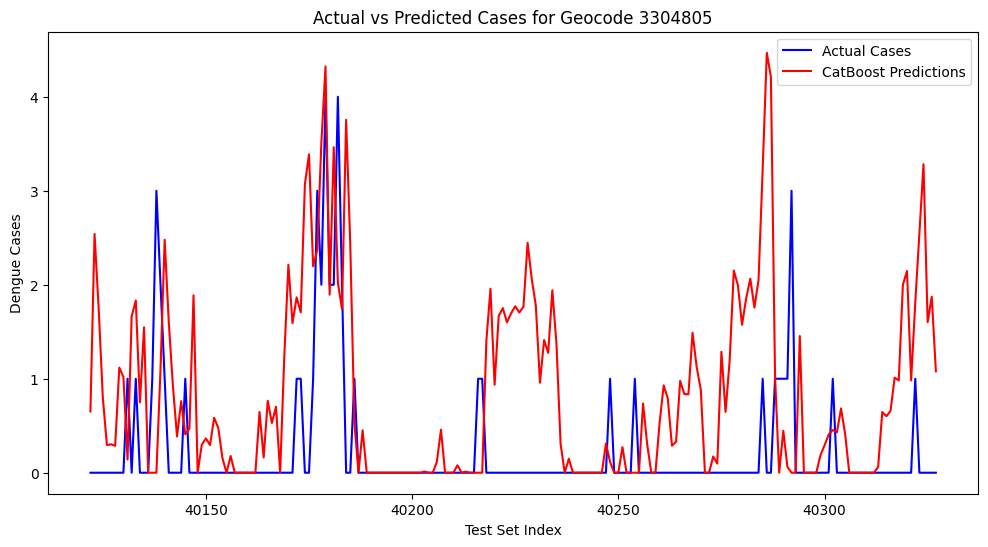

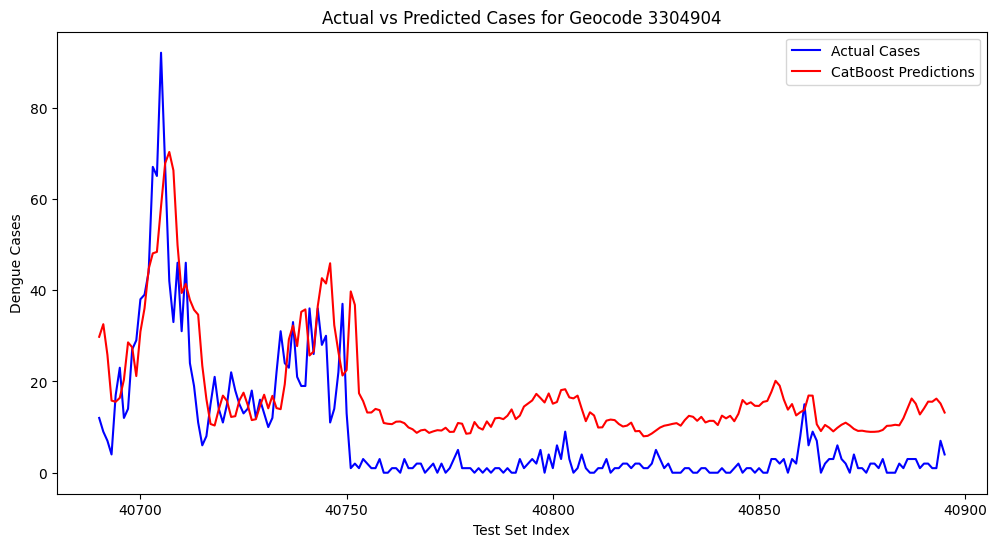

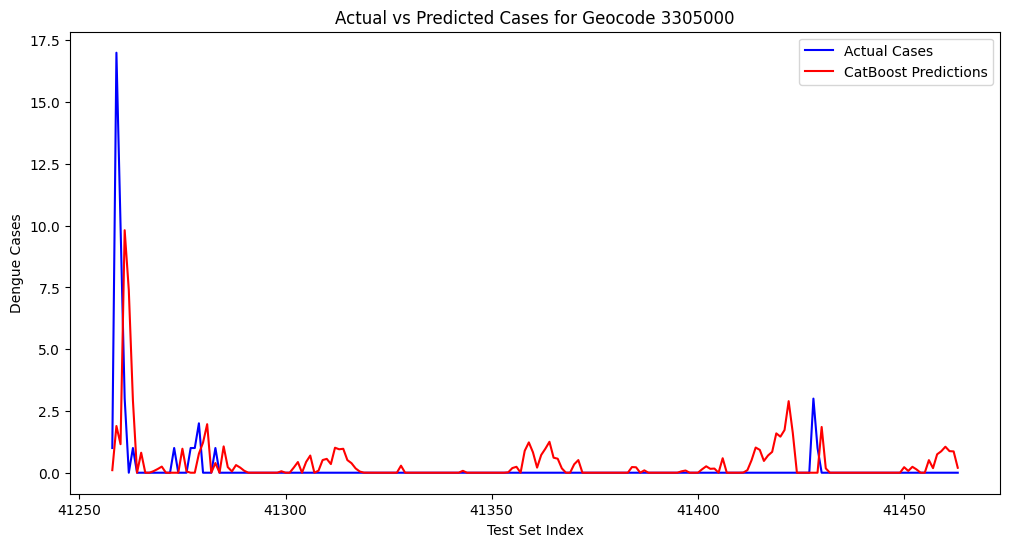

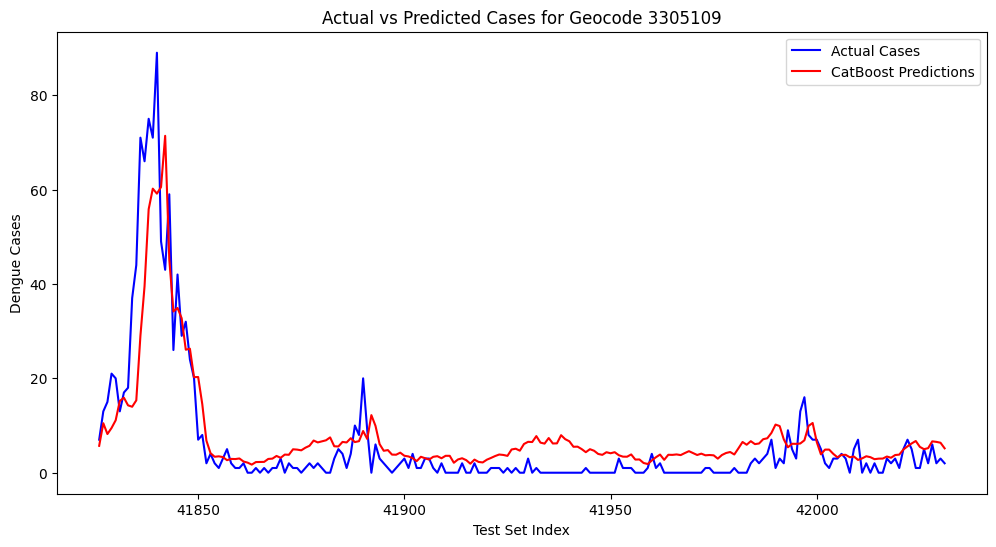

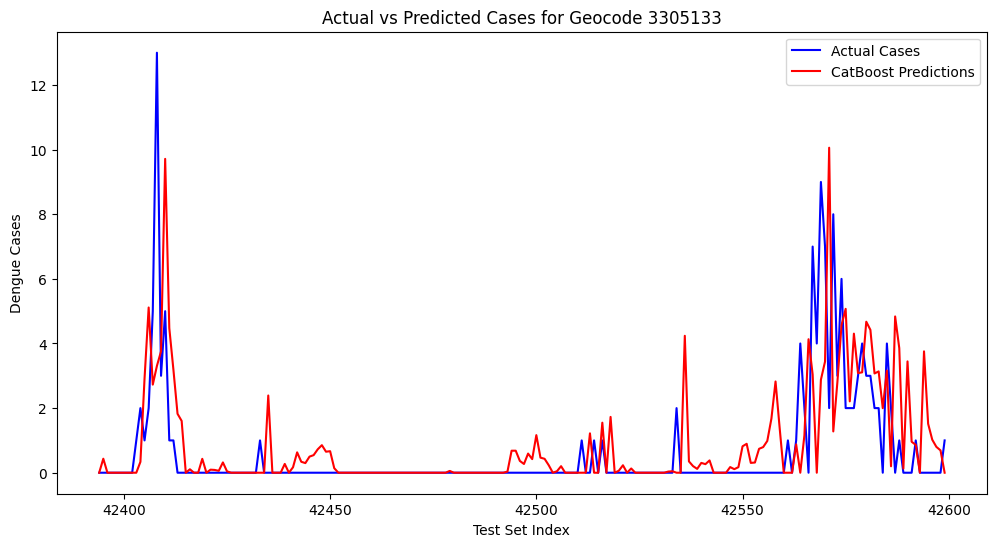

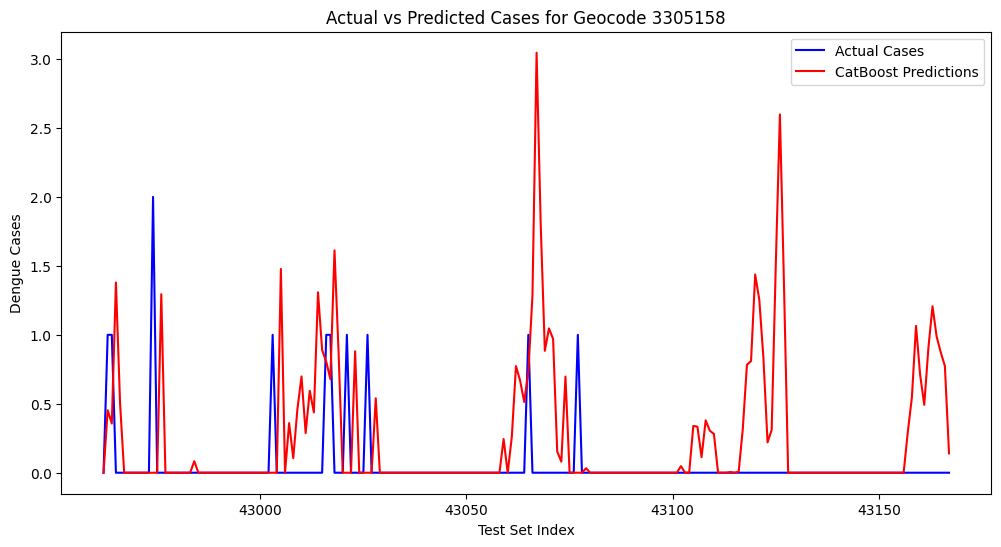

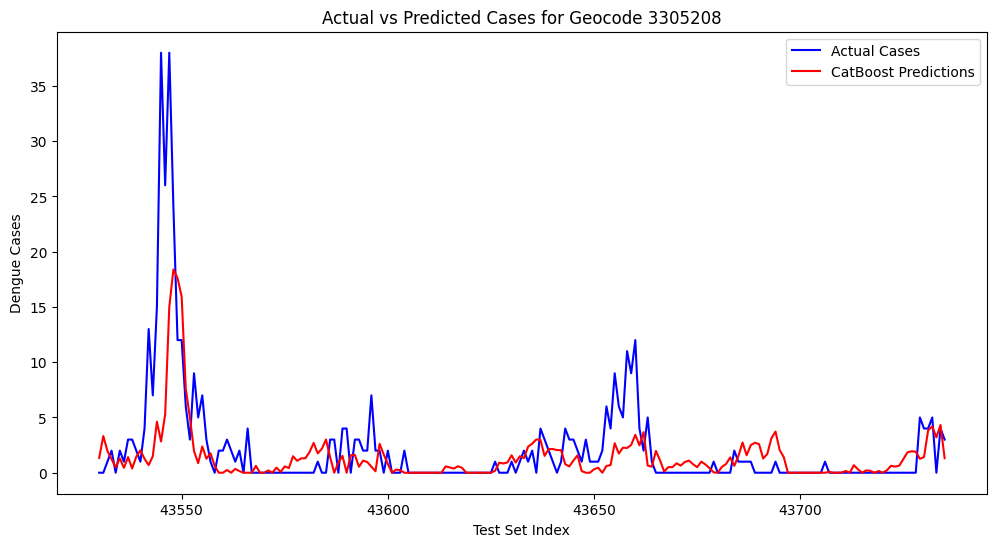

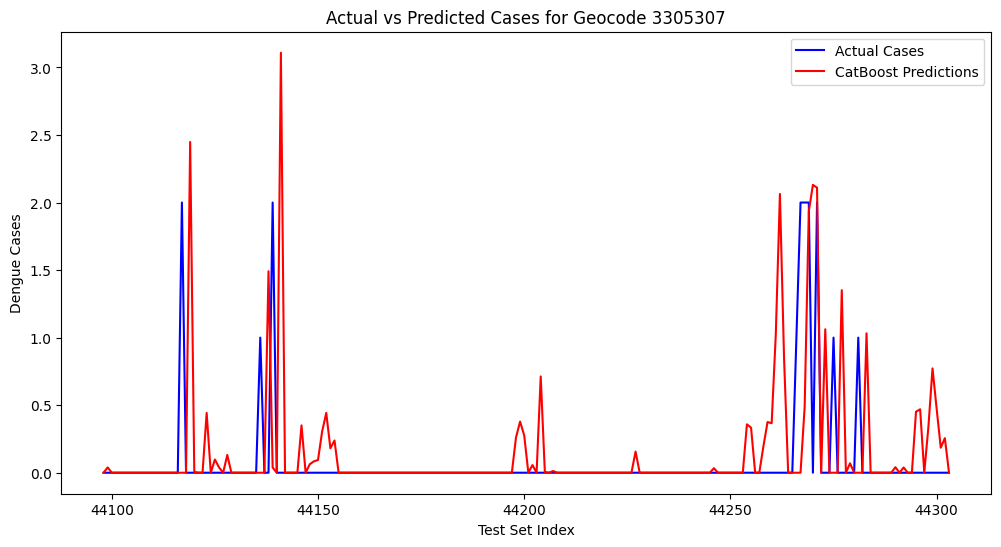

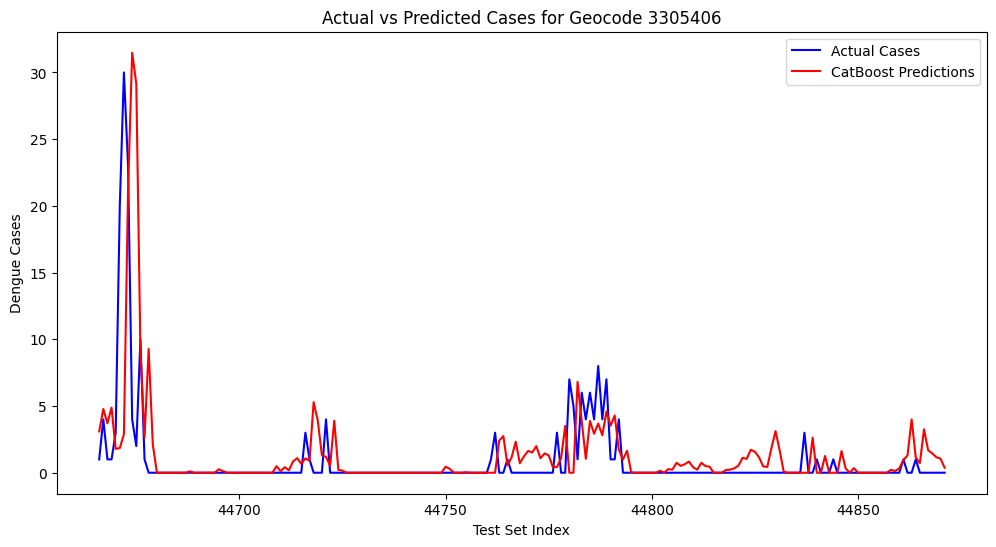

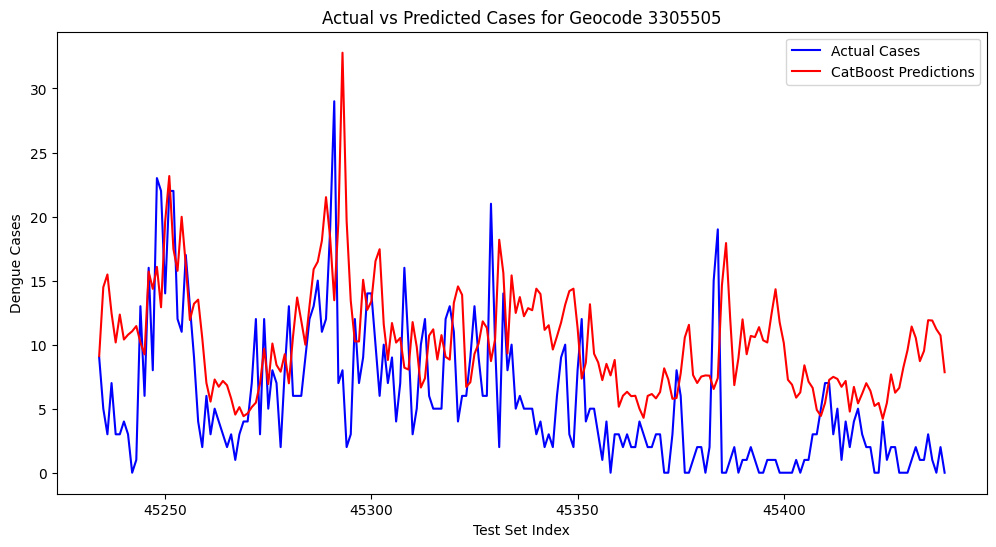

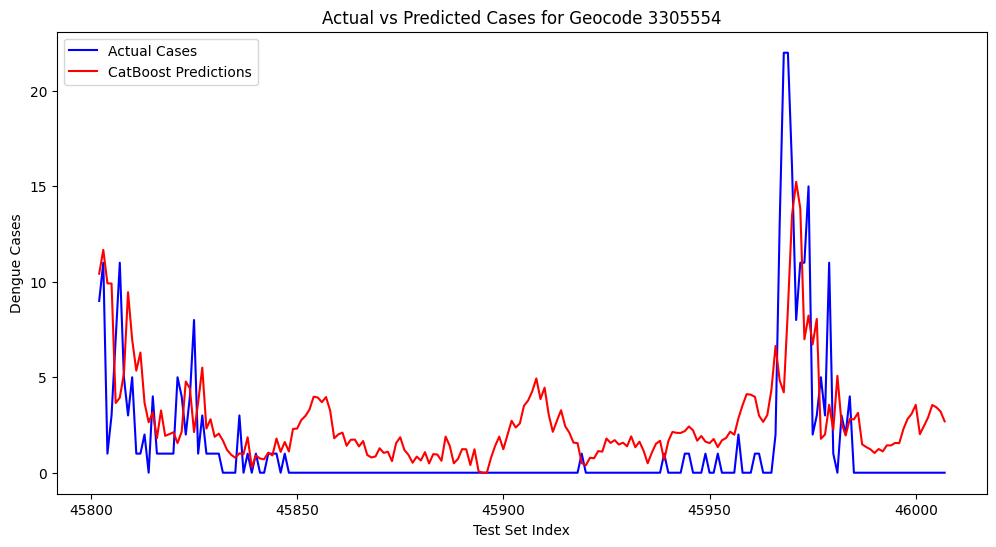

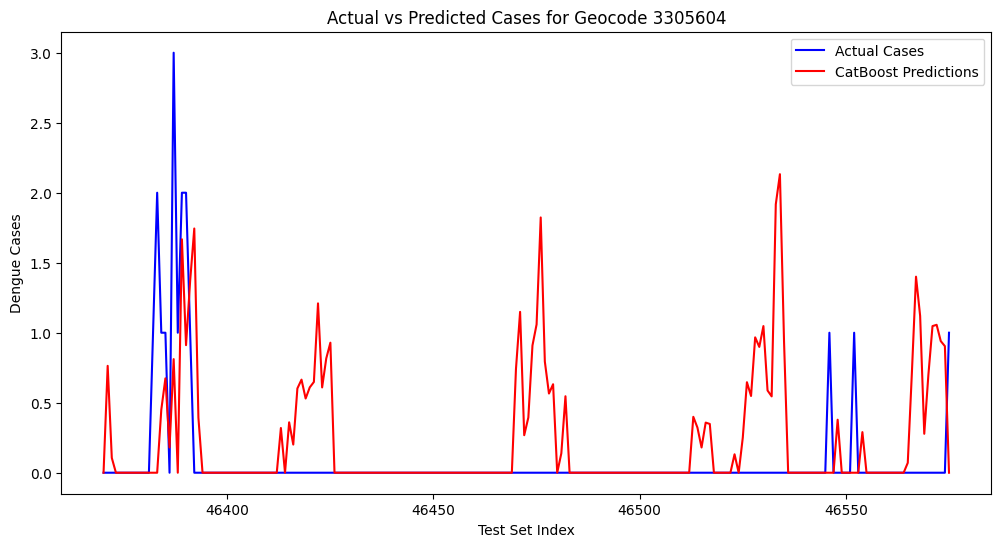

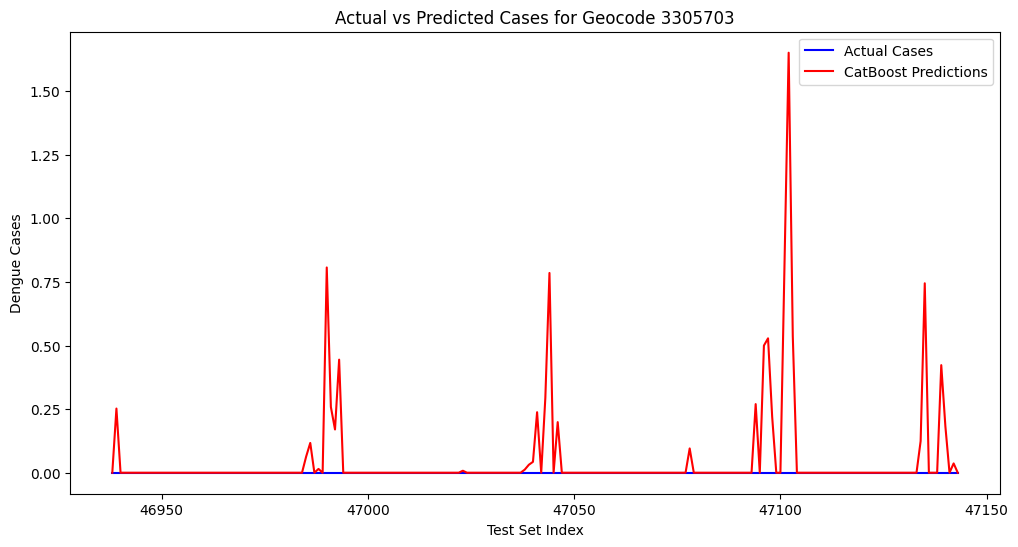

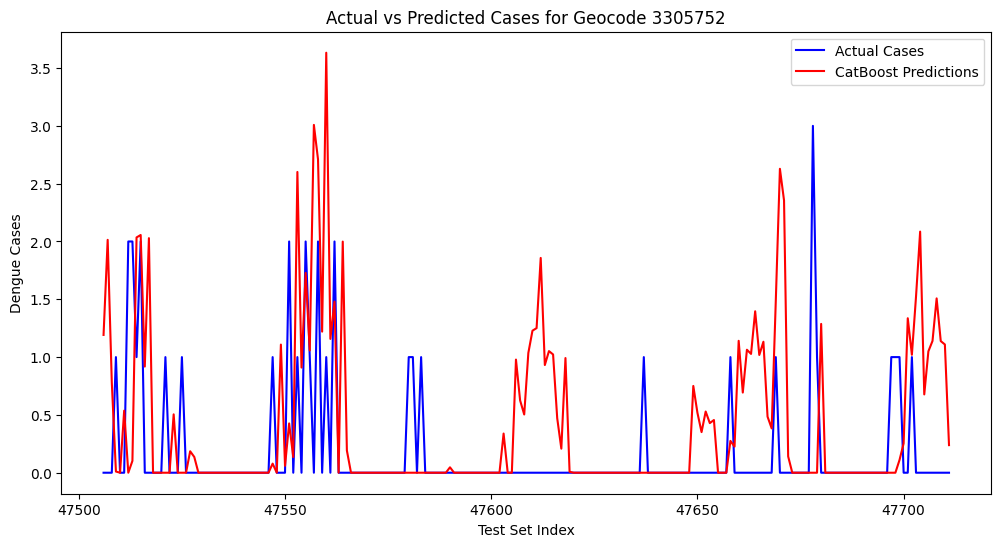

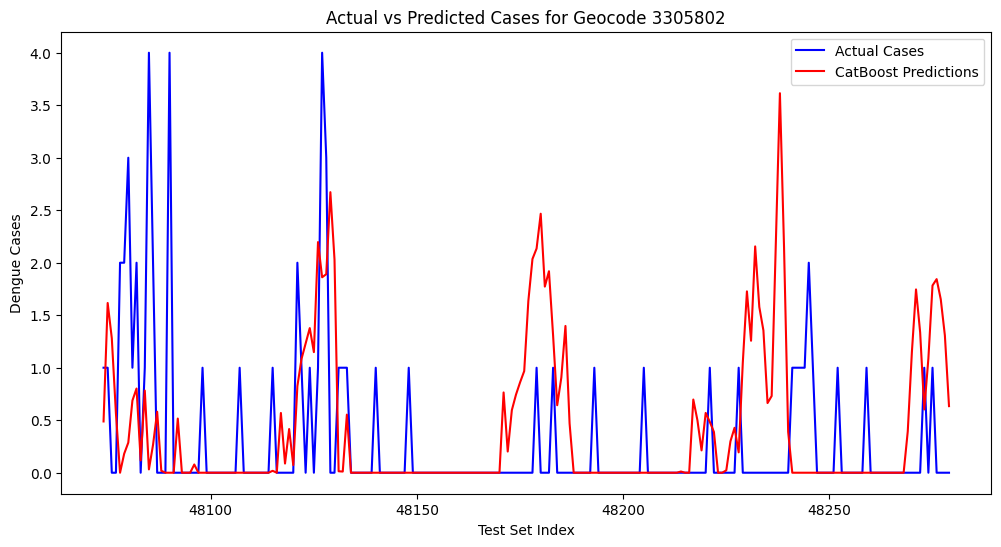

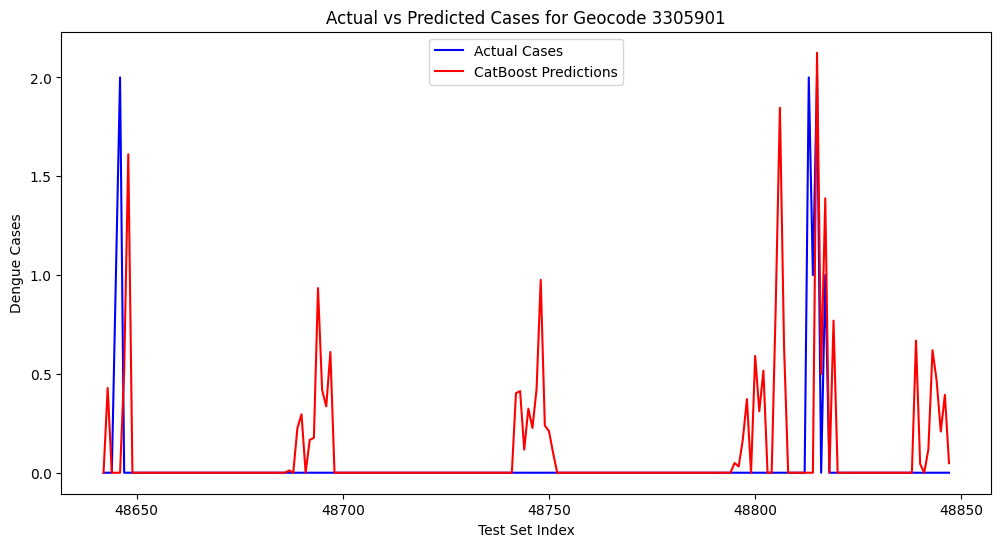

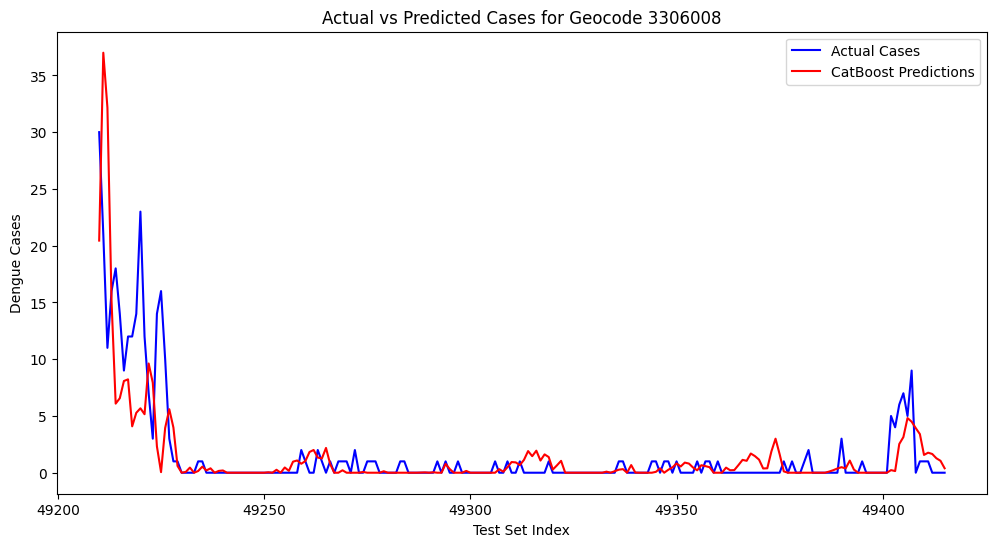

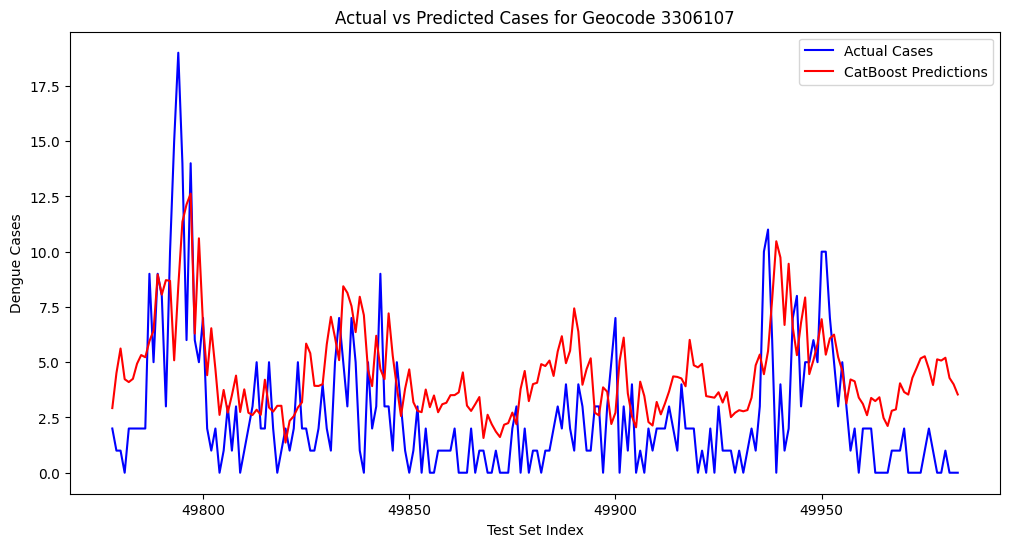

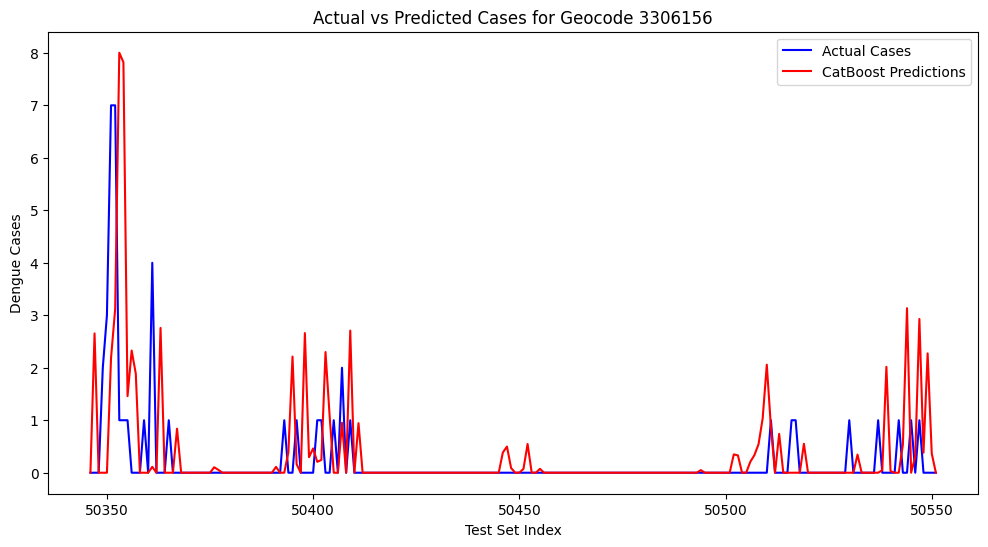

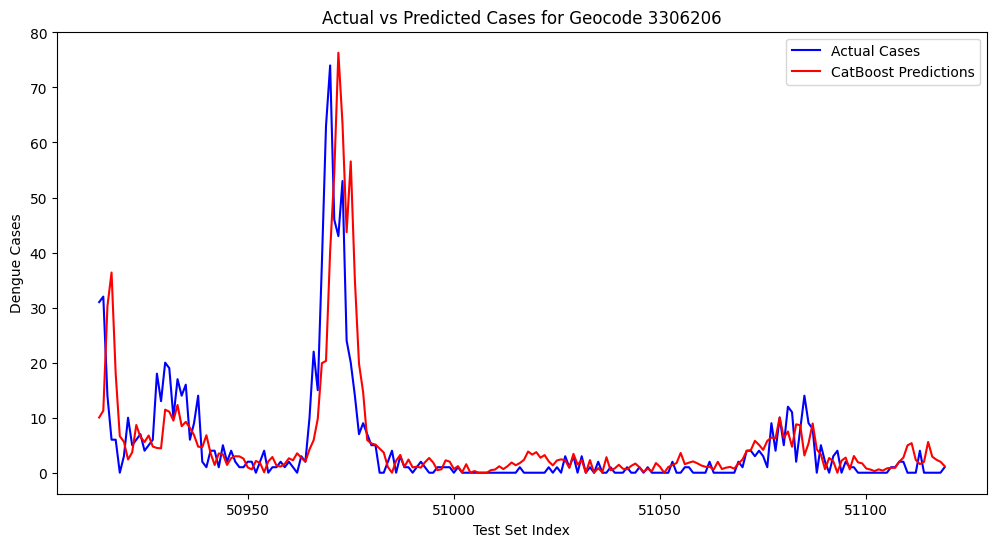

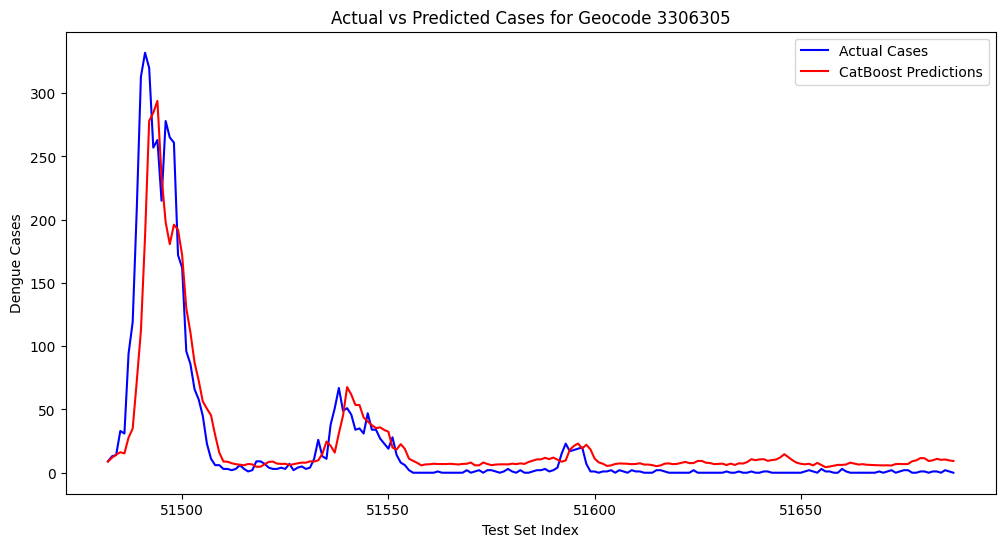

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

# Step 1: Define columns that should not be scaled
columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                        'geocode', 'year_sin', 'year_cos']

# Step 2: Define selected features
selected_columns = [
    'cases_lag0', 'cases_lag1', 'geocode',
     'temp_avg', 'humidity_avg',
    'precipitation_avg_ordinary_kriging_lag3',
    'precipitation_avg_ordinary_kriging_lag4',
    'week_sin', 'month_sin', 'week_cos', 'month_cos',
    'week','vim','cases_per_100k'
]

# Step 3: Select features
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Step 4: Scale numerical features
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                    and col not in columns_not_to_scale]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

# Step 5: Scale target variables
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

# Step 6: Define parameter grid for RandomizedSearchCV
# param_grid = {
#     'iterations': [1500],
#     'learning_rate': [0.05],
#     'depth': [4],
#     'l2_leaf_reg': [9],
#     'bagging_temperature': [0],
#     'random_strength': [1],
#     'border_count': [128],
#     'boosting_type': ['Ordered', 'Plain'],
#     'early_stopping_rounds': [100],
#     'verbose': [100]
# }

param_grid = {
    'iterations': [500, 750, 1000],  # Fewer iterations to prevent overfitting
    'learning_rate': [0.01, 0.03, 0.05],  # Smaller learning rate to slow learning
    'depth': [4, 5, 6],  # Shallower trees generalize better
    'l2_leaf_reg': [5, 7, 9, 11, 13],  # Stronger L2 regularization
    'bagging_temperature': [0.5, 1, 2, 5],  # Introduce randomness in sampling
    'random_strength': [5, 10, 15],  # More randomness in splits for regularization
    'border_count': [32, 64],  # Keep reasonable splits, avoid overly complex trees
    'boosting_type': ['Plain'],  # Faster and often generalizes better with large data
    'early_stopping_rounds': [50, 100],  # Early stopping to avoid overfitting
    'verbose': [100]  # Logging frequency
}

# Step 7: Initialize CatBoost model
catboost_model = CatBoostRegressor(loss_function='RMSE', cat_features=['geocode'])

# Step 8: Hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train_scaled)

# Step 9: Retrieve best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Step 10: Make predictions using best model
y_train_pred_cb_scaled = best_model.predict(X_train)
y_test_pred_cb_scaled = best_model.predict(X_test)

# Step 11: Inverse scaling
y_train_pred_cb = target_scaler.inverse_transform(y_train_pred_cb_scaled.reshape(-1, 1)).ravel()
y_train_pred_cb = np.clip(y_train_pred_cb, 0, None)

y_test_pred_cb = target_scaler.inverse_transform(y_test_pred_cb_scaled.reshape(-1, 1)).ravel()
y_test_pred_cb = np.clip(y_test_pred_cb, 0, None)

# Step 12: Evaluate performance
train_rmse_cb = np.sqrt(mean_squared_error(y_train, y_train_pred_cb))
test_rmse_cb = np.sqrt(mean_squared_error(y_test, y_test_pred_cb))
train_r2_cb = r2_score(y_train, y_train_pred_cb)
test_r2_cb = r2_score(y_test, y_test_pred_cb)

print("\nCatBoost Model Performance:")
print("CatBoost RMSE (Train):", train_rmse_cb)
print("CatBoost RMSE (Test):", test_rmse_cb)
print("CatBoost R² (Train):", train_r2_cb)
print("CatBoost R² (Test):", test_r2_cb)

# Step 13: Feature Importance
importance_cb = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_model.feature_importances_})
importance_cb = importance_cb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_cb['Feature'], importance_cb['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost Model")
plt.gca().invert_yaxis()
plt.show()

# Step 14: Visualization - Actual vs Predicted per Geocode
unique_geocodes = X_test['geocode'].unique()

for geocode in unique_geocodes:
    geocode_mask = X_test['geocode'] == geocode
    y_test_geocode = y_test[geocode_mask]
    y_test_pred_cb_geocode = y_test_pred_cb[geocode_mask]
    
    indices = X_test[geocode_mask].index
    
    plt.figure(figsize=(12, 6))
    plt.plot(indices, y_test_geocode, label="Actual Cases", color='b')
    plt.plot(indices, y_test_pred_cb_geocode, label="CatBoost Predictions", color='r')
    plt.xlabel("Test Set Index")
    plt.ylabel("Dengue Cases")
    plt.title(f"Actual vs Predicted Cases for Geocode {geocode}")
    plt.legend()
    plt.show()


In [8]:
# Create DataFrame for predictions with geocode
test_data_with_preds = test_data.copy()
test_data_with_preds = test_data_with_preds.reset_index(drop=True)

# Ensure geocode is string for consistency and sorting
test_data_with_preds['geocode'] = test_data_with_preds['geocode'].astype(str)

# Add predictions and actual values
test_data_with_preds['catboost_pred'] = y_test_pred_cb
test_data_with_preds['actual'] = y_test.values.ravel()

# Filter and save for 2019
catboost_preds_2019 = test_data_with_preds[test_data_with_preds['year'] == 2019][['geocode', 'week', 'catboost_pred', 'actual']]
catboost_preds_2019.to_csv('catboost_preds_2019.csv', index=False)

# Filter and save for 2020
catboost_preds_2020 = test_data_with_preds[test_data_with_preds['year'] == 2020][['geocode', 'week','catboost_pred', 'actual']]
catboost_preds_2020.to_csv('catboost_preds_2020.csv', index=False)

# Filter and save for 2021
catboost_preds_2021 = test_data_with_preds[test_data_with_preds['year'] == 2021][['geocode', 'week','catboost_pred', 'actual']]
catboost_preds_2021.to_csv('catboost_preds_2021.csv', index=False)

# Filter and save for 2022
catboost_preds_2022 = test_data_with_preds[test_data_with_preds['year'] == 2022][['geocode', 'week','catboost_pred', 'actual']]
catboost_preds_2022.to_csv('catboost_preds_2022.csv', index=False)

print("Saved CatBoost predictions for 2019, 2020, 2021, and 2022.")

Saved CatBoost predictions for 2019, 2020, 2021, and 2022.
